In [1]:
import os
os.chdir('/mnt/ialabnas/homes/fidelrio/systematic-text-representations/')

from itertools import product, chain
import json
from pathlib import Path
import random
import pprint

import numpy as np
from PIL import Image
from tqdm.auto import tqdm, trange

from config import load_config
from data import build_datasets
from data import CollatorForMaskedSelectedTokens, CollatorForMaskedRandomSelectedTokens, IdentityCollator
from data import ALL_POSSIBLE_COLORS
from model import MultimodalModel, MultimodalPretrainingModel
from lightning import Trainer, seed_everything

import torch
from torch.utils.data import DataLoader, Subset
from torch.nn.functional import softmax

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.dpi'] = 130
mpl.rcParams['font.size'] = 7
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['figure.dpi'] = 120

pp = pprint.PrettyPrinter(indent=2)

In [2]:
def scene_tensor_to_txt(tensor):
    return ' '.join([processor.inv_vocabulary[t] for t in tensor.tolist()])

def print_scene_tensor(tensor):
    scene_text = scene_tensor_to_txt(tensor)
    print(scene_text.replace('[PAD]', '').replace('[SEP]','\n     '))
    
def print_parallel(tensor0, tensor1, tensor2, confidences, titles):
    ttl0, ttl1, ttl2 = titles
    print(f'{ttl0:6.6s} {ttl1:6.6s} {ttl2:6.6s}')
    for t0, t1, t2, conf in zip(
            tensor0.tolist(), tensor1.tolist(), tensor2.tolist(), confidences.tolist()):
        w0 = processor.inv_vocabulary[t0]
        w1 = processor.inv_vocabulary[t1]
        w2 = processor.inv_vocabulary[t2]
        
        if w0 == '[SEP]':
            print()
            continue
        if w0 == '[PAD]':
            break
        
        print_txt = f'{w0:6.6s} {w1:6.6s} {w2:6.6s} ({conf:.4f})'
        if w0 != w2:
            print_txt = bold(print_txt)
            

        print(print_txt)
        
def bold(text):
    return ("\033[1m" + text + "\033[0m")

def multicolumn_barplot(y_groups,
                        x_labels,
                        y_labels,
                        y_groups_errors=None,
                        title='',
                        x_label='',
                        y_label='',
                        legend_loc='',
                        ylim=None,
                        bar_colors=None,
                        return_bars=False):

    plt.figure(figsize=(9*0.75,5*0.75))

    bar_width = 1 / (len(y_groups)+1)

    if not bar_colors:
        bar_colors = [None]*len(y_groups)

    start_offset = -0.5*len(y_groups)+0.5
    bars = []
    for idx, (label, color, y) in enumerate(zip(y_labels, bar_colors, y_groups)):
        offset = start_offset + idx
        kwargs = {}
        if y_groups_errors is not None:
            kwargs['yerr'] = y_groups_errors[idx]
        bars.append(plt.bar([x + offset*bar_width for x in range(len(x_labels))],
                            y,
                            width=bar_width,
                            label=label,
                            color=color,
                            **kwargs
                            ))
    
#     xs =  list(range(len(x_labels)))
#     for i, ys in enumerate(zip(*y_groups)):
#         for idx, y in enumerate(ys):
#             offset = start_offset + idx
#             plt.text(xs[i] + offset*bar_width, y + 0.01, f'{y:.2f}', ha='center')

    plt.xticks(range(len(x_labels)), x_labels)
    
    # Add labels and title
    if title:
        plt.title(title)
    if x_label:
        plt.xlabel(x_label)
    if y_label:
        plt.ylabel(y_label)
    if legend_loc:
        plt.legend(framealpha=1, loc=legend_loc)
    if ylim:
        plt.ylim(*ylim)
    if return_bars:
        return bars

In [3]:
def read_metric(result, category, metric):
    if metric == 'random_baseline':
        return result['random_baseline'][category]
    
#     metric_mode = 'random'
#     if metric in ('systematic_test_acc', 'common_systematic_test_acc'):
#         metric_mode = 'random_without_testing_spheres'
    metric_mode = 'random_without_testing_spheres'
        
    metric_idx, metric_name = {
        f'test_acc': (0, 'test_acc/dataloader_idx_0'),
        f'systematic_test_acc': (1, 'systematic_test_acc/dataloader_idx_1'),
        f'common_systematic_test_acc': (3, 'common_systematic_test_acc/dataloader_idx_1'),
        f'train_acc': (2, 'train_acc/dataloader_idx_0'),
    }[metric]
    
    return result[metric_mode][category][metric_idx][metric_name]


def get_num_colors(base_path):
    if 'colored' not in base_path:
        return 8
    num_colors = int(base_path.split('/')[-1][:-1])
    return num_colors


class ExperimentSuite:
    def __init__(self, exp_dicts):
        self.experiments = []
        self.indexed_experiments = {}
        for exp_dict in exp_dicts:
            self.append_experiment(exp_dict)
        
    def append_experiment(self, exp_dict):
        exp_name = self.standarize_name(exp_dict['exp_name'])
        if exp_name in self.indexed_experiments:
            base_exp = self.indexed_experiments[exp_name]
            base_exp.update_with(exp_dict)
            return
            
        exp = Experiment.from_dict(exp_dict)
        self.indexed_experiments[exp_name] = exp
        self.experiments.append(exp)
        
    def standarize_name(self, exp_name):
        return exp_name.split('--seed=')[0]
    
    @property
    def experiment_names(self):
        return list(self.indexed_experiments.keys())
    
    def get_exp(self, exp_name):
        return self.indexed_experiments[exp_name]
    
    def read_exp_metric(self, exp_name_or_names, task, metric, mode='random_without_testing_spheres', return_err=False):
        if isinstance(exp_name_or_names, list):
            exp_names = exp_name_or_names
            result = [
                self.get_exp(exp_name).read_metric(task, metric, mode=mode, return_err=return_err)
                for exp_name in exp_names
            ]
            if return_err:
                return list(zip(*result))
            return result
            
        exp_name = exp_name_or_names
        return self.get_exp(exp_name).read_metric(
            task, metric, mode=mode, return_err=return_err)


class Experiment:
    result_keys = ['selected', 'random', 'random_baseline', 'nmi_scores', 'sampled_nmi_scores', 
                   'random_without_testing_spheres']
    optional_keys = ['p_scores', 'p_scores_within_task', 'probing_metrics',                    
                     'o_scores_within_color_shape', 'o_scores_within_task', 'o_scores']
    
    def __init__(self, exp_name, config, runs):
        self.exp_name = exp_name
        self.config = config
        self.runs = runs
        
    @classmethod
    def from_dict(cls, experiment_dict):
        exp_name = experiment_dict['exp_name']
        config = experiment_dict['config']
        seed = config['seed']
        results = cls.read_results(cls, experiment_dict)
        return cls(exp_name, config, [ExperimentRun(seed, results)])
    
    def update_with(self, experiment_dict):
        exp_name = experiment_dict['exp_name']
        new_config = experiment_dict['config']
        self._check_updating_config(new_config)
        seed = new_config['seed']
        results = self.read_results(self, experiment_dict)
        self.runs.append(ExperimentRun(seed, results))
    
    @staticmethod
    def read_results(self_or_cls, experiment_dict):
        try:
            results = {k: experiment_dict[k] for k in self_or_cls.result_keys}
            optional_results = {k: experiment_dict[k] for k in self_or_cls.optional_keys if k in experiment_dict}
            results = {**results, **optional_results}
        except KeyError as e:
            print(exp_name)
            raise e
        return results
    
    def _check_updating_config(self, new_cofig):
        # Check config are the same or raise warning
        print('_check_updating_config not implemented yet.')
        
    def read_metric(self, task, metric, mode='random_without_testing_spheres', return_err=False):
        result = []
        for run in self.runs:
            result.append(self.read_metric_from(run, task, metric, mode=mode))
            
        if return_err:
            return np.mean(result), (np.std(result) / len(result))
        return np.mean(result)
        
    def read_metric_from(self, result, task, metric, mode='random_without_testing_spheres'):
        if metric == 'random_baseline':
            return result['random_baseline'][task]

        metric_idx, metric_name = {
            f'test_acc': (0, 'test_acc/dataloader_idx_0'),
            f'systematic_test_acc': (1, 'systematic_test_acc/dataloader_idx_1'),
            f'common_systematic_test_acc': (3, 'common_systematic_test_acc/dataloader_idx_1'),
            f'train_acc': (2, 'train_acc/dataloader_idx_0'),
        }[metric]

        return result[mode][task][metric_idx][metric_name]
        
    @property
    def categories(self):
        return list(self.runs[0].results['selected'].keys())
        
class ExperimentRun:
    def __init__(self, seed, results):
        self.seed = seed
        self.results = results
        
    def __getitem__(self, idx):
        return self.results[idx]
    
    def __len__(self):
        return len(self.results)

In [4]:
filter_experiments = lambda p: 'mmlm--n_colors=' in p.stem

results_dir = Path('outputs/results/')
all_results = [
    {'exp_name': p.stem, **json.load(p.open())} for p in results_dir.glob('*.json')
    if filter_experiments(p)
]

# all_results

In [5]:
all_experiments = ExperimentSuite(all_results)

_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not implemented yet.
_check_updating_config not imple

In [6]:
all_experiments.experiment_names

['mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=27',
 'mmlm--n_colors=125c--mlm_probability=0.15',
 'mmlm--n_colors=216c--mlm_probability=0.15',
 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=16',
 'mmlm--n_colors=64c--mlm_probability=0.15',
 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=32',
 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=8',
 'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=1728-indep',
 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=128-no-indep',
 'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=864-no-indep',
 'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=1728-no-indep',
 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=512-indep',
 'mmlm--n_colors=8c--d_hidden=128',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=192-indep',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=32-indep',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=64-no

## Base Dataset

In [7]:
base_exp = all_experiments.get_exp('mmlm--n_colors=8c--mlm_probability=0.15')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


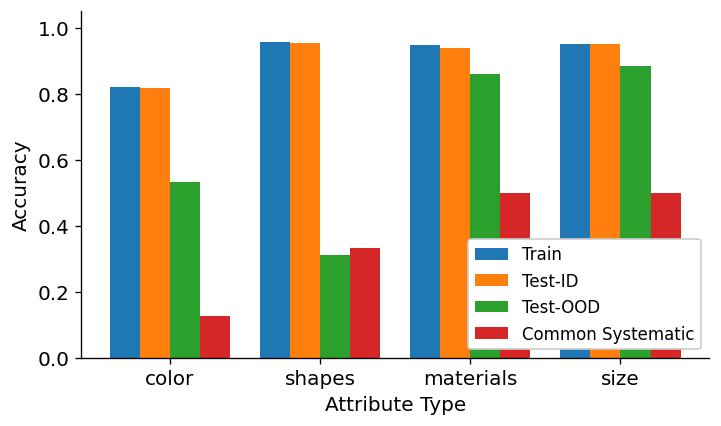

In [8]:
categories = base_exp.categories
category_labels = [c.capitalize() for c in categories]

base_train_accs = [base_exp.read_metric(cat, 'train_acc', mode='selected') for cat in categories]
base_test_accs = [base_exp.read_metric(cat, 'test_acc', mode='selected') for cat in categories]
base_syst_accs = [base_exp.read_metric(cat, 'systematic_test_acc', mode='selected') for cat in categories]
base_csyst_accs = [base_exp.read_metric(cat, 'common_systematic_test_acc', mode='selected') for cat in categories]
base_random_accs = [base_exp.read_metric(cat, 'random_baseline', mode='selected') for cat in categories]


# y_labels = ['Train', 'Test', 'Systematic', 'Random']
y_labels = ['Train', 'Test-ID', 'Test-OOD', 'Common Systematic', 'Random']

(bar_train,
 bar_test,
 bar_syst,
#  bar_cmn_syst,
 bar_random) = multicolumn_barplot(
                    (base_train_accs, base_test_accs, base_syst_accs, base_random_accs),
#                     (base_train_accs, base_test_accs, base_syst_accs, base_csyst_accs, base_random_accs),
                    categories, y_labels,
                    x_label='Attribute Type',
                    y_label='Accuracy',
                    ylim=(0., 1.05),
#                     title='Performance in Base Dataset',
                    legend_loc='lower right',
                    return_bars=True,
                   )

In [9]:
train_color = bar_train[0].get_facecolor()
test_color = bar_test[0].get_facecolor()
syst_color = bar_syst[0].get_facecolor()
# cmn_syst_color = bar_cmn_syst[0].get_facecolor()
random_color = bar_random[0].get_facecolor()

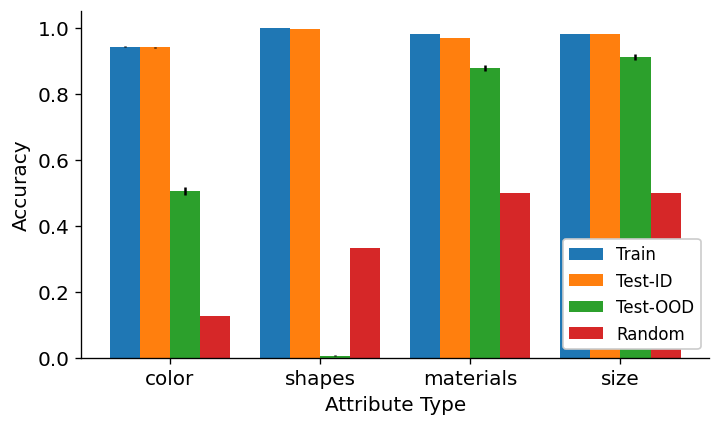

In [10]:
categories = base_exp.categories
category_labels = [c.capitalize() for c in categories]

base_train_accs, base_train_err = zip(
    *[base_exp.read_metric(cat, 'train_acc', return_err=True) for cat in categories])
base_test_accs, base_test_err = zip(
    *[base_exp.read_metric(cat, 'test_acc', return_err=True) for cat in categories])
base_syst_accs, base_syst_err = zip(
    *[base_exp.read_metric(cat, 'systematic_test_acc', return_err=True) for cat in categories])
base_csyst_accs, base_csyst_err = zip(
    *[base_exp.read_metric(cat, 'common_systematic_test_acc', return_err=True) for cat in categories])
base_random_accs, base_random_err = zip(
    *[base_exp.read_metric(cat, 'random_baseline', return_err=True) for cat in categories])


y_labels = ['Train', 'Test-ID', 'Test-OOD', 'Random']
# y_labels = ['Train', 'Test', 'Systematic', 'Common Systematic', 'Random']

(bar_train,
 bar_test,
 bar_syst,
#  bar_cmn_syst,
 bar_random) = multicolumn_barplot(
                    (base_train_accs, base_test_accs, base_syst_accs, base_random_accs),
#                     (base_train_accs, base_test_accs, base_syst_accs, base_csyst_accs, base_random_accs),
                    categories,
                    y_labels,
                    y_groups_errors=[base_train_err, base_test_err, base_syst_err, base_random_err],
                    x_label='Attribute Type',
                    y_label='Accuracy',
                    ylim=(0., 1.05),
#                     title='Performance in Base Dataset',
                    legend_loc='lower right',
                    return_bars=True,
                   )

# Show plot
plt.savefig('exports/all_tasks_base.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# TODO:
# Same graph by shape
# Confusion Matrices

In [12]:
# all_experiments.get_exp('mmlm--n_colors=8c--mlm_probability=0.15').runs

## New colors

In [13]:
new_colors_exps_names = [
    f'mmlm--n_colors={n_colors}c--mlm_probability=0.15' for n_colors in [8, 27, 64, 125, 216]
]
new_colors_results = [r for r in all_results if r['exp_name'] in new_colors_exps_names]
new_colors_results = sorted(new_colors_results, key=lambda r: get_num_colors(r['config']['base_path']))

In [14]:
num_colors = [get_num_colors(r['config']['base_path']) for r in new_colors_results]
categories = ['colors', 'shapes']
category_labels = [c.capitalize() for c in categories]

color_tests, color_tests_err = all_experiments.read_exp_metric(
    new_colors_exps_names, 'color', 'test_acc', return_err=True)
color_system, color_system_err = all_experiments.read_exp_metric(
    new_colors_exps_names, 'color', 'systematic_test_acc', return_err=True)
color_cmn_system, color_cmn_system_err = all_experiments.read_exp_metric(
    new_colors_exps_names, 'color', 'common_systematic_test_acc', return_err=True)
color_random, color_random_err = all_experiments.read_exp_metric(
    new_colors_exps_names, 'color', 'random_baseline', return_err=True)
shape_tests, shape_tests_err = all_experiments.read_exp_metric(
    new_colors_exps_names, 'shapes', 'test_acc', return_err=True)
shape_system, shape_system_err = all_experiments.read_exp_metric(
    new_colors_exps_names, 'shapes', 'systematic_test_acc', return_err=True)
shape_cmn_system, shape_cmn_system_err = all_experiments.read_exp_metric(
    new_colors_exps_names, 'shapes', 'common_systematic_test_acc', return_err=True)
shape_random, shape_random_err = all_experiments.read_exp_metric(
    new_colors_exps_names, 'shapes', 'random_baseline', return_err=True)

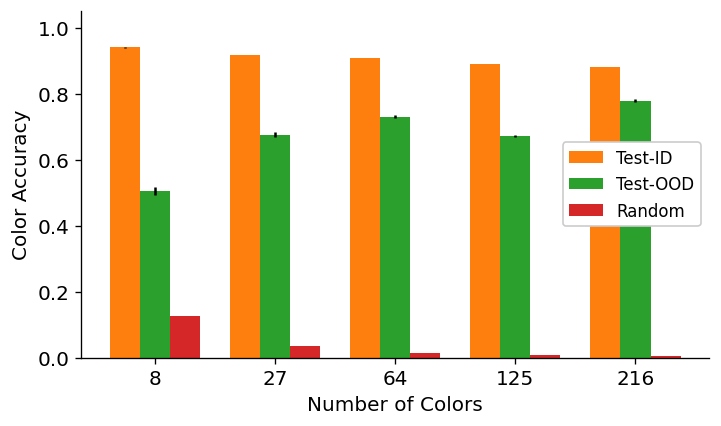

In [15]:
multicolumn_barplot([color_tests, color_system, color_random],
#                     [color_tests, color_system, color_cmn_system, color_random],
                    num_colors,
                    ['Test-ID', 'Test-OOD', 'Random'],
#                     ['Test', 'Systematic', 'Common Systematic', 'Random'],
#                     title='Performance in Base Dataset (Random Masking)',
                    y_groups_errors=[color_tests_err, color_system_err, color_random_err],
#                     y_groups_errors=[color_tests_err, color_system_err, color_cmn_system_err, color_random_err],
                    x_label='Number of Colors',
                    y_label='Color Accuracy',
                    legend_loc='center right',
                    ylim=(0., 1.05),
                    bar_colors=[test_color, syst_color, random_color])
#                     bar_colors=[test_color, syst_color, cmn_syst_color, random_color])


# Show plot
plt.savefig('exports/color_task_by_colors.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

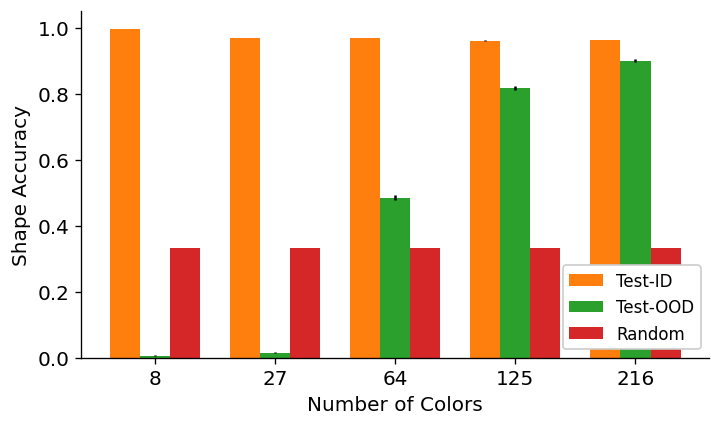

In [16]:
multicolumn_barplot([shape_tests, shape_system, shape_random],
#                     [shape_tests, shape_system, shape_cmn_system, shape_random],
                    num_colors,
                    ['Test-ID', 'Test-OOD', 'Random'],
#                     ['Test', 'Systematic', 'Common Systematic', 'Random'],
#                     title='Performance in Base Dataset (Random Masking)',
                    y_groups_errors=[shape_tests_err, shape_system_err, shape_random_err],
#                     y_groups_errors=[shape_tests_err, shape_system_err, shape_cmn_system_err, shape_random_err],
                    x_label='Number of Colors',
                    y_label='Shape Accuracy',
                    legend_loc='lower right',
                    ylim=(0., 1.05),
                    bar_colors=[test_color, syst_color, random_color])
#                     bar_colors=[test_color, syst_color, cmn_syst_color, random_color])

plt.savefig('exports/shape_task_by_colors.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


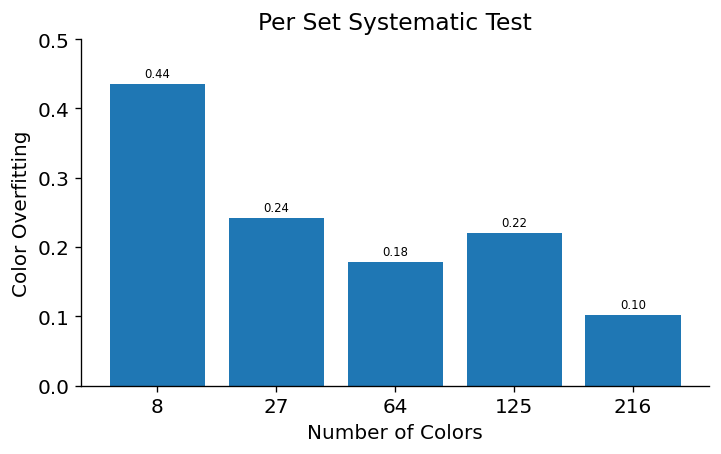

In [17]:
plt.figure(figsize=(9*0.75,5*0.75))

# Define width of bars
bar_width = 0.5

color_diff = np.array(color_tests) - np.array(color_system)
# Create bars for each category
plt.bar([x for x in range(len(num_colors))], color_diff)

xs =  list(range(len(num_colors)))
for i, v0 in enumerate(color_diff):
    plt.text(xs[i], v0 + 0.01, f'{v0:.2f}', ha='center')

# Add labels and title
plt.title('Per Set Systematic Test')
plt.xlabel('Number of Colors')
plt.ylabel('Color Overfitting')
plt.ylim(0., 0.5)
plt.xticks(range(len(num_colors)), num_colors)

# Show plot
plt.savefig('exports/diff-colors-by-num-colors.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
# plt.figure(figsize=(9*0.75,5*0.75))

# # Define width of bars
# bar_width = 0.5

# color_diff = np.array(color_tests) - np.array(color_cmn_system)
# # Create bars for each category
# plt.bar([x for x in range(len(num_colors))], color_diff)

# xs =  list(range(len(num_colors)))
# for i, v0 in enumerate(color_diff):
#     plt.text(xs[i], v0 + 0.01, f'{v0:.2f}', ha='center')

# # Add labels and title
# plt.title('Common Systematic Test')
# plt.xlabel('Number of Colors')
# plt.ylabel('Color Overfitting')
# plt.ylim(0., 0.5)
# plt.xticks(range(len(num_colors)), num_colors)

# # Show plot
# plt.savefig('exports/diff-colors-by-num-colors.pdf', format='pdf', dpi=300, bbox_inches='tight')
# plt.show()

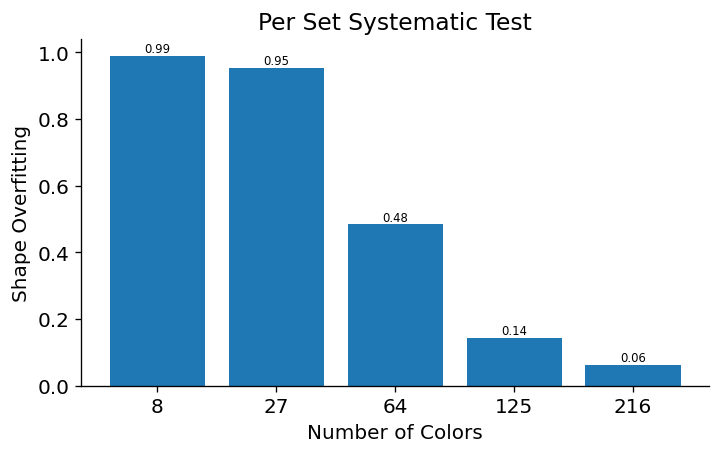

In [19]:
plt.figure(figsize=(9*0.75,5*0.75))

# Define width of bars
bar_width = 0.5

shape_diff = np.array(shape_tests) - np.array(shape_system)
# Create bars for each category
plt.bar([x for x in range(len(num_colors))], shape_diff)

xs =  list(range(len(num_colors)))
for i, v0 in enumerate(shape_diff):
    plt.text(xs[i], v0 + 0.01, f'{v0:.2f}', ha='center')

# Add labels and title
plt.title('Per Set Systematic Test')
plt.xlabel('Number of Colors')
plt.ylabel('Shape Overfitting')
# plt.ylim(0., 1.05)
plt.xticks(range(len(num_colors)), num_colors)

# Show plot
plt.savefig('exports/diff-shapes-by-num-colors.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# plt.figure(figsize=(9*0.75,5*0.75))

# # Define width of bars
# bar_width = 0.5

# shape_diff = np.array(shape_tests) - np.array(shape_cmn_system)
# # Create bars for each category
# plt.bar([x for x in range(len(num_colors))], shape_diff)

# xs =  list(range(len(num_colors)))
# for i, v0 in enumerate(shape_diff):
#     plt.text(xs[i], v0 + 0.01, f'{v0:.2f}', ha='center')

# # Add labels and title
# plt.title('Common Systematic Test')
# plt.xlabel('Number of Colors')
# plt.ylabel('Shape Overfitting')
# # plt.ylim(0., 1.05)
# plt.xticks(range(len(num_colors)), num_colors)

# # Show plot
# plt.savefig('exports/diff-shapes-by-num-colors.pdf', format='pdf', dpi=300, bbox_inches='tight')
# plt.show()

In [21]:
def get_num_clusters(r):
    if not r['config'].get('token_translation_path'):
        return get_num_colors(r['config']['base_path'])
    return int(r['config']['token_translation_path'].replace('.json','').split('to_')[-1])

In [22]:
pre = 'mmlm'
suf = 'mlm_probability=0.15'

lo_exps_names = [
#     f'{pre}--{suf}',
    *[f'{pre}--n_colors={cnum}--{suf}' for cnum in ['64c', '216c']],
    *[f'{pre}--n_colors={cnum}--{suf}--overloading_to={lo_num}' 
          for cnum, lo_num in chain(product(['64c'], ['8','16','32']), product(['216c'], ['8', '27','54','108']))],
]
lo_results = [r for r in all_results if r['exp_name'] in lo_exps_names]
lo_results = sorted(lo_results, key=lambda r: (get_num_colors(r['config']['base_path']), -get_num_clusters(r)))

In [23]:
num_colors = [get_num_colors(r['config']['base_path']) for r in lo_results]
num_clusters = [get_num_clusters(r) for r in lo_results]
uniq_num_colors = sorted(list(set(num_colors)))
categories = ['colors', 'shapes']
category_labels = [c.capitalize() for c in categories]

color_tests = [read_metric(r, 'color', 'test_acc') for r in lo_results] 
color_system = [read_metric(r, 'color', 'systematic_test_acc') for r in lo_results] 

shape_tests = [read_metric(r, 'shapes', 'test_acc') for r in lo_results] 
shape_system = [read_metric(r, 'shapes', 'systematic_test_acc') for r in lo_results] 

In [24]:
all_overfitting_color = []
all_overfitting_shape = []
all_num_colors = []
all_num_clusters = []
all_color_test_acc = []
all_color_systematic_test_acc = []
all_shapes_test_acc = []
all_shapes_systematic_test_acc = []

for num in uniq_num_colors:
    overfitting_color = []
    overfitting_shape = []
    num_colors = []
    num_clusters = []
    color_test_acc = []
    color_systematic_test_acc = []
    shapes_test_acc = []
    shapes_systematic_test_acc = []
    for r in lo_results:
        if get_num_colors(r['config']['base_path']) != num:
            continue
        c_test_acc = read_metric(r, 'color', 'test_acc')
        c_systematic_test_acc = read_metric(r, 'color', 'systematic_test_acc')
        s_test_acc = read_metric(r, 'shapes', 'test_acc')
        s_systematic_test_acc = read_metric(r, 'shapes', 'systematic_test_acc')
        
        color_test_acc.append(c_test_acc)
        color_systematic_test_acc.append(c_systematic_test_acc)
        shapes_test_acc.append(s_test_acc)
        shapes_systematic_test_acc.append(s_systematic_test_acc)
        overfitting_color.append(
            c_test_acc - c_systematic_test_acc)
        overfitting_shape.append(
            s_test_acc - s_systematic_test_acc)
        num_colors.append(get_num_colors(r['config']['base_path']))
        num_clusters.append(get_num_clusters(r))

    all_color_test_acc.append(color_test_acc)
    all_color_systematic_test_acc.append(color_systematic_test_acc)
    all_shapes_test_acc.append(shapes_test_acc)
    all_shapes_systematic_test_acc.append(shapes_systematic_test_acc)
    all_overfitting_color.append(overfitting_color)
    all_overfitting_shape.append(overfitting_shape)
    all_num_colors.append(num_colors)
    all_num_clusters.append(num_clusters)

In [25]:
t_all_overfitting_shape = list(zip(*all_overfitting_shape))
t_all_overfitting_color = list(zip(*all_overfitting_color))

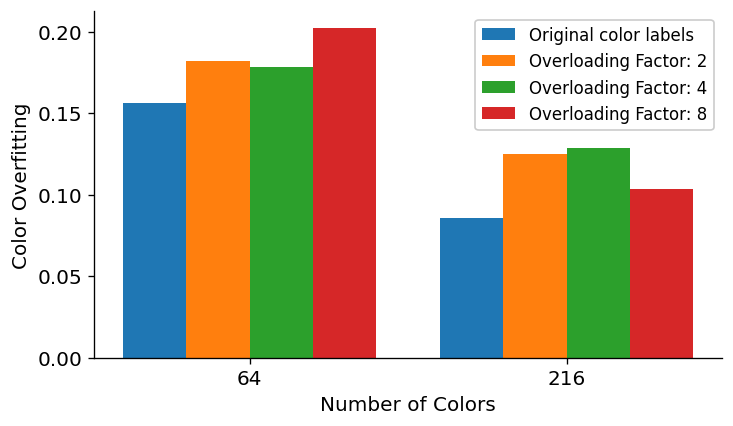

In [26]:
y_labels = ['Original color labels', 'Overloading Factor: 2', 'Overloading Factor: 4', 'Overloading Factor: 8']

multicolumn_barplot(t_all_overfitting_color, uniq_num_colors, y_labels,
                    title='',
                    x_label='Number of Colors',
                    y_label='Color Overfitting',
                    legend_loc='upper right')


# Show plot
plt.savefig('exports/diff-colors-by-label-overloading.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

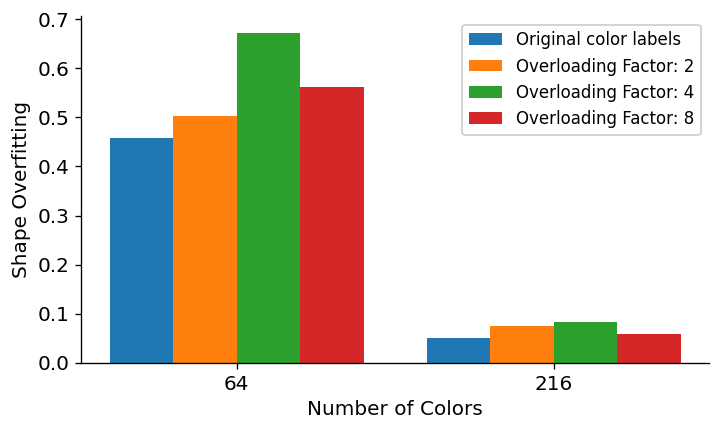

In [27]:
y_labels = ['Original color labels', 'Overloading Factor: 2', 'Overloading Factor: 4', 'Overloading Factor: 8']

multicolumn_barplot(t_all_overfitting_shape, uniq_num_colors, y_labels,
                    title='',
                    x_label='Number of Colors',
                    y_label='Shape Overfitting',
                    legend_loc='upper right')


# Show plot
plt.savefig('exports/diff-shapes-by-label-overloading.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

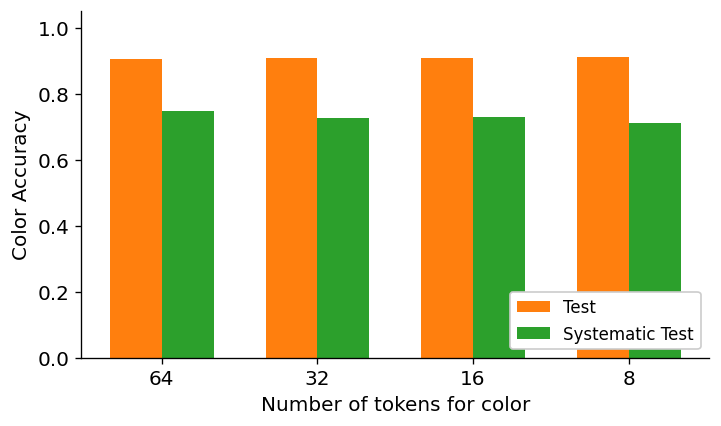

In [28]:
y_labels = ['Test', 'Systematic Test']
bar_colors = [test_color, syst_color]

multicolumn_barplot([all_color_test_acc[0], all_color_systematic_test_acc[0]],
                    all_num_clusters[0],
                    y_labels,
#                     title='64 Colors in Images',
                    x_label='Number of tokens for color',
                    y_label='Color Accuracy',
                    ylim=(0., 1.05),
                    legend_loc='lower right',
                    bar_colors=bar_colors,
                   )


# Show plot
plt.savefig('exports/acc-colors-by-label-overloading-64.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

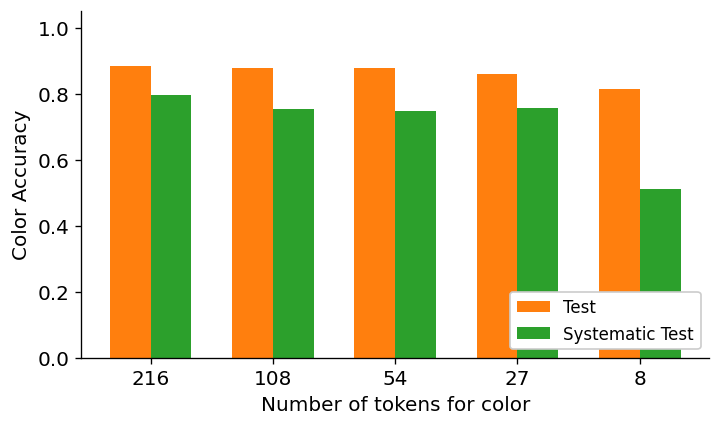

In [29]:
y_labels = ['Test', 'Systematic Test']
bar_colors = [test_color, syst_color]

multicolumn_barplot([all_color_test_acc[1], all_color_systematic_test_acc[1]],
                    all_num_clusters[1],
                    y_labels,
#                     title='216 Colors in Images',
                    x_label='Number of tokens for color',
                    y_label='Color Accuracy',
                    ylim=(0., 1.05),
                    legend_loc='lower right',
                    bar_colors=bar_colors,
                   )

# Show plot
plt.savefig('exports/acc-colors-by-label-overloading-216.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

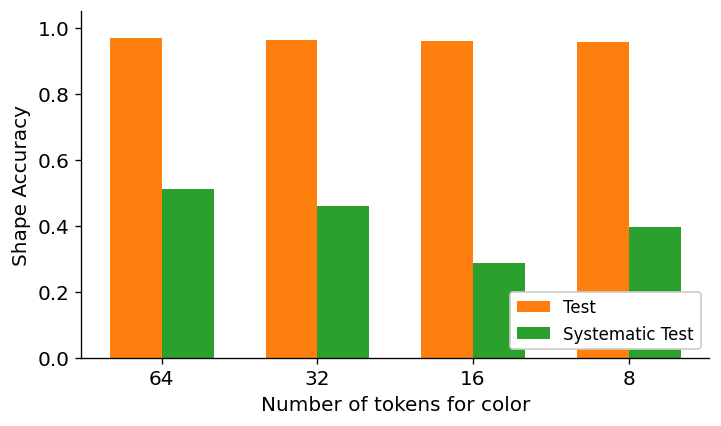

In [30]:
y_labels = ['Test', 'Systematic Test']
bar_colors = [test_color, syst_color]

multicolumn_barplot([all_shapes_test_acc[0], all_shapes_systematic_test_acc[0]], all_num_clusters[0], y_labels,
#                     title='64 Colors in Images',
                    x_label='Number of tokens for color',
                    y_label='Shape Accuracy',
                    ylim=(0., 1.05),
                    legend_loc='lower right',
                    bar_colors=bar_colors,
                   )

# Show plot
plt.savefig('exports/acc-shapes-by-label-overloading-64.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

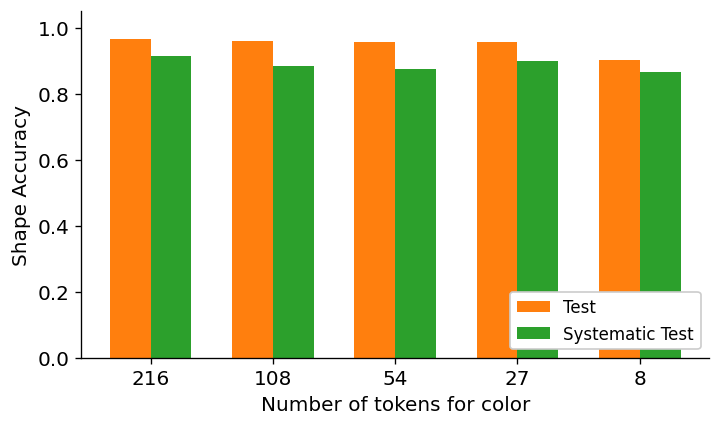

In [31]:
y_labels = ['Test', 'Systematic Test']
bar_colors = [test_color, syst_color]

multicolumn_barplot([all_shapes_test_acc[1], all_shapes_systematic_test_acc[1]], all_num_clusters[1], y_labels,
#                     title='216 Colors in Images',
                    x_label='Number of tokens for color',
                    y_label='Shape Accuracy',
                    ylim=(0., 1.05),
                    legend_loc='lower right',
                    bar_colors=bar_colors,
                   )

# Show plot
plt.savefig('exports/acc-shapes-by-label-overloading-216.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [32]:
colors_test, colors_test_err = all_experiments.read_exp_metric(
    [
        'mmlm--n_colors=8c--mlm_probability=0.15',
        'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=8',
        'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=8'
    ],
    'color',
    'test_acc',
    return_err=True,
)
colors_syst, colors_syst_err = all_experiments.read_exp_metric(
    [
        'mmlm--n_colors=8c--mlm_probability=0.15',
        'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=8',
        'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=8'
    ],
    'color',
    'systematic_test_acc',
    return_err=True,
)
# colors_cmn_syst = [
#     read_metric(base_result, 'colors', 'common_systematic_test_acc'),
# ]
shapes_test, shapes_test_err = all_experiments.read_exp_metric(
    [
        'mmlm--n_colors=8c--mlm_probability=0.15',
        'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=8',
        'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=8'
    ],
    'shapes',
    'test_acc',
    return_err=True,
)
shapes_syst, shapes_syst_err = all_experiments.read_exp_metric(
    [
        'mmlm--n_colors=8c--mlm_probability=0.15',
        'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=8',
        'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=8'
    ],
    'shapes',
    'systematic_test_acc',
    return_err=True,
)
# shapes_cmn_syst = [
#     read_metric(base_result, 'shapes', 'common_systematic_test_acc'),
# ]

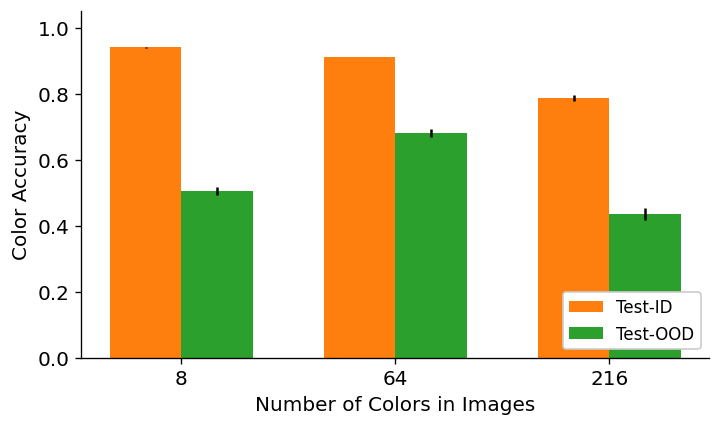

In [33]:
y_labels = ['Test-ID', 'Test-OOD']
bar_colors = [test_color, syst_color]

multicolumn_barplot([colors_test, colors_syst],
                    [8, 64, 216],
                    y_labels,
#                     title='8 tokens for color',
                    x_label='Number of Colors in Images',
                    y_label='Color Accuracy',
                    ylim=(0., 1.05),
                    y_groups_errors=[colors_test_err,colors_syst_err],
                    legend_loc='lower right',
                    bar_colors=bar_colors,
                   )

# Show plot
plt.savefig('exports/color-task-overloading-to-8-labels.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

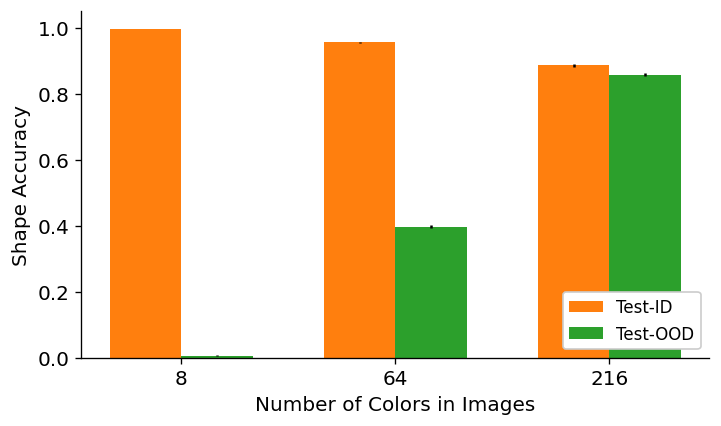

In [34]:
y_labels = ['Test-ID', 'Test-OOD']
bar_colors = [test_color, syst_color]

multicolumn_barplot([shapes_test, shapes_syst],
                    [8, 64, 216],
                    y_labels,
#                     title='8 tokens for color',
                    x_label='Number of Colors in Images',
                    y_label='Shape Accuracy',
                    ylim=(0., 1.05),
                    y_groups_errors=[shapes_test_err,shapes_syst_err],
                    legend_loc='lower right',
                    bar_colors=bar_colors,
                   )

# Show plot
plt.savefig('exports/shape-task-overloading-to-8-labels.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [35]:
[n for n in all_experiments.experiment_names if 'mmlm--n_colors=8c' in n]

['mmlm--n_colors=8c--d_hidden=128',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=192-indep',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=32-indep',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=64-no-indep',
 'mmlm--n_colors=8c--mlm_probability=0.15',
 'mmlm--n_colors=8c--d_hidden=32',
 'mmlm--n_colors=8c--d_hidden=64',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=32-no-indep',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=800-indep',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=800-no-indep',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=192-no-indep',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=96-no-indep',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=64-indep',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=96-indep']

In [36]:
[n for n in all_experiments.experiment_names if 'mmlm--n_colors=64c' in n]

['mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=16',
 'mmlm--n_colors=64c--mlm_probability=0.15',
 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=32',
 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=8',
 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=128-no-indep',
 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=512-indep',
 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=128-indep',
 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=512-no-indep',
 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=256-indep',
 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=256-no-indep']

In [37]:
experiment_group = [
#     'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=8',
#     'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=16',
#     'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=32',
    'mmlm--n_colors=64c--mlm_probability=0.15',
    'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=128-indep',
    'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=256-indep',
    'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=512-indep',
]
xs = [64, 128, 216, 512] 
# xs = [8, 16, 32, 64, 128, 216, 512] 

colors_test = all_experiments.read_exp_metric(experiment_group, 'color', 'test_acc')
colors_syst = all_experiments.read_exp_metric(experiment_group, 'color', 'systematic_test_acc')
# colors_cmn_syst = all_experiments.read_exp_metric(experiment_group, 'color', 'common_systematic_test_acc')

shapes_test = all_experiments.read_exp_metric(experiment_group, 'shapes', 'test_acc')
shapes_syst = all_experiments.read_exp_metric(experiment_group, 'shapes', 'systematic_test_acc')
# shapes_cmn_syst = all_experiments.read_exp_metric(experiment_group, 'shapes', 'common_systematic_test_acc')

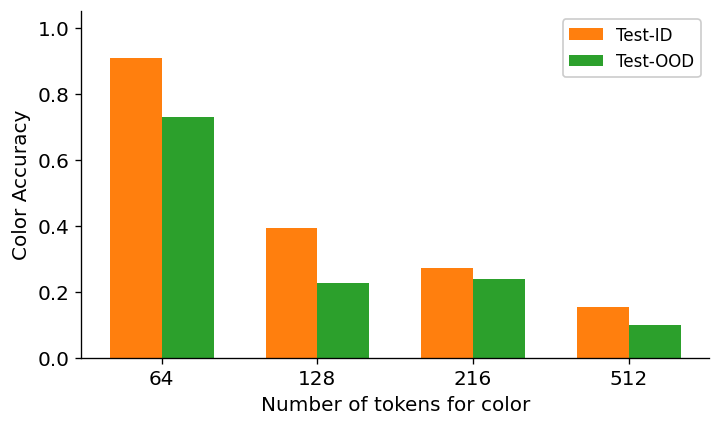

In [38]:
y_labels = ['Test-ID', 'Test-OOD']
bar_colors = [test_color, syst_color]

multicolumn_barplot([colors_test, colors_syst],
                    xs,
                    y_labels,
#                     title='Overloading with 64 Colors in Images',
                    x_label='Number of tokens for color',
                    y_label='Color Accuracy',
                    ylim=(0., 1.05),
                    legend_loc='upper right',
                    bar_colors=bar_colors,
                   )

# Show plot
plt.savefig(
    'exports/acc-color-by-label-underloading-indep-64.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

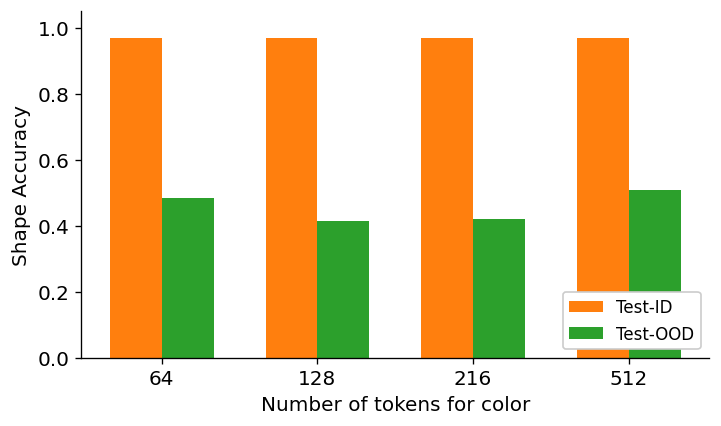

In [39]:
y_labels = ['Test-ID', 'Test-OOD']
bar_colors = [test_color, syst_color]

multicolumn_barplot([shapes_test, shapes_syst],
                    xs,
                    y_labels,
#                     title='Overloading with 64 Colors in Images',
                    x_label='Number of tokens for color',
                    y_label='Shape Accuracy',
                    ylim=(0., 1.05),
                    legend_loc='lower right',
                    bar_colors=bar_colors,
                   )

# Show plot
plt.savefig(
    'exports/acc-shape-by-label-underloading-indep-64.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

## Non-Contextual Underloading

In [40]:
[n for n in all_experiments.experiment_names if 'mmlm--n_colors=8c' in n]

['mmlm--n_colors=8c--d_hidden=128',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=192-indep',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=32-indep',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=64-no-indep',
 'mmlm--n_colors=8c--mlm_probability=0.15',
 'mmlm--n_colors=8c--d_hidden=32',
 'mmlm--n_colors=8c--d_hidden=64',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=32-no-indep',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=800-indep',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=800-no-indep',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=192-no-indep',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=96-no-indep',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=64-indep',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=96-indep']

In [41]:
experiment_group = [
    'mmlm--n_colors=8c--mlm_probability=0.15',
    'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=32-indep',
    'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=192-indep',
    'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=800-indep',
]
xs = [8, 32, 192, 800] 
# xs = [8, 16, 32, 64, 128, 256, 512] 

colors_test = all_experiments.read_exp_metric(experiment_group, 'color', 'test_acc')
colors_syst = all_experiments.read_exp_metric(experiment_group, 'color', 'systematic_test_acc')
# colors_cmn_syst = all_experiments.read_exp_metric(experiment_group, 'color', 'common_systematic_test_acc')

shapes_test = all_experiments.read_exp_metric(experiment_group, 'shapes', 'test_acc')
shapes_syst = all_experiments.read_exp_metric(experiment_group, 'shapes', 'systematic_test_acc')
# shapes_cmn_syst = all_experiments.read_exp_metric(experiment_group, 'shapes', 'common_systematic_test_acc')

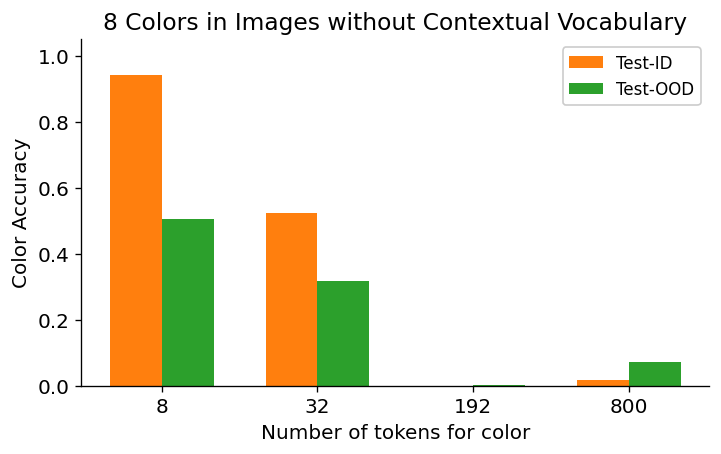

In [42]:
y_labels = ['Test-ID', 'Test-OOD']
bar_colors = [test_color, syst_color]

multicolumn_barplot([colors_test, colors_syst],
                    xs,
                    y_labels,
                    title='8 Colors in Images without Contextual Vocabulary',
                    x_label='Number of tokens for color',
                    y_label='Color Accuracy',
                    ylim=(0., 1.05),
                    legend_loc='upper right',
                    bar_colors=bar_colors,
                   )

# Show plot
plt.savefig(
    'exports/acc-color-by-label-underloading-indep-8.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

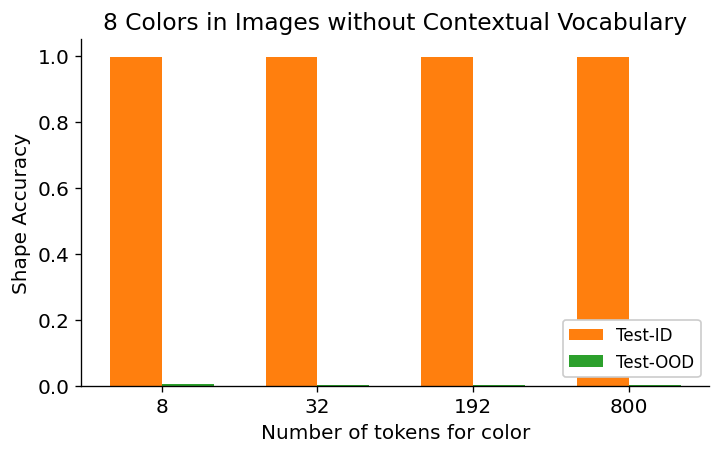

In [43]:
y_labels = ['Test-ID', 'Test-OOD']
bar_colors = [test_color, syst_color]

multicolumn_barplot([shapes_test, shapes_syst],
                    xs,
                    y_labels,
                    title='8 Colors in Images without Contextual Vocabulary',
                    x_label='Number of tokens for color',
                    y_label='Shape Accuracy',
                    ylim=(0., 1.05),
                    legend_loc='lower right',
                    bar_colors=bar_colors,
                   )

# Show plot
plt.savefig(
    'exports/acc-shape-by-label-underloading-indep-8.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [44]:
[n for n in all_experiments.experiment_names if 'mmlm--n_colors=216c' in n]

['mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=27',
 'mmlm--n_colors=216c--mlm_probability=0.15',
 'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=1728-indep',
 'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=864-no-indep',
 'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=1728-no-indep',
 'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=8',
 'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=432-indep',
 'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=864-indep',
 'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=54',
 'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=108']

In [45]:
experiment_group = [
#     'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=8',
#     'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=27',
#     'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=54',
#     'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=108',
    'mmlm--n_colors=216c--mlm_probability=0.15',
    'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=432-indep',
    'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=864-indep',
    'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=1728-indep',
]
xs = [216, 432, 864, 1728] 
# xs = [8, 27, 54, 108, 216, 432, 864, 1728] 

colors_test = all_experiments.read_exp_metric(experiment_group, 'color', 'test_acc')
colors_syst = all_experiments.read_exp_metric(experiment_group, 'color', 'systematic_test_acc')
# colors_cmn_syst = all_experiments.read_exp_metric(experiment_group, 'color', 'common_systematic_test_acc')

shapes_test = all_experiments.read_exp_metric(experiment_group, 'shapes', 'test_acc')
shapes_syst = all_experiments.read_exp_metric(experiment_group, 'shapes', 'systematic_test_acc')
# shapes_cmn_syst = all_experiments.read_exp_metric(experiment_group, 'shapes', 'common_systematic_test_acc')

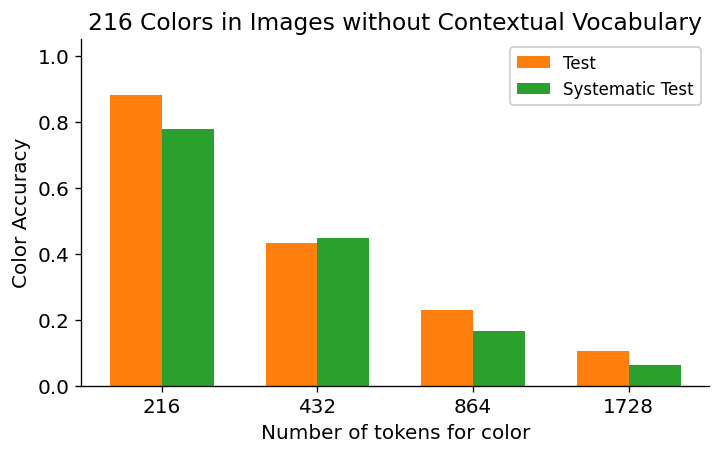

In [46]:
y_labels = ['Test', 'Systematic Test']
bar_colors = [test_color, syst_color]

multicolumn_barplot([colors_test, colors_syst],
                    xs,
                    y_labels,
                    title='216 Colors in Images without Contextual Vocabulary',
                    x_label='Number of tokens for color',
                    y_label='Color Accuracy',
                    ylim=(0., 1.05),
                    legend_loc='upper right',
                    bar_colors=bar_colors,
                   )

# Show plot
plt.savefig(
    'exports/acc-color-by-label-underloading-indep-216.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

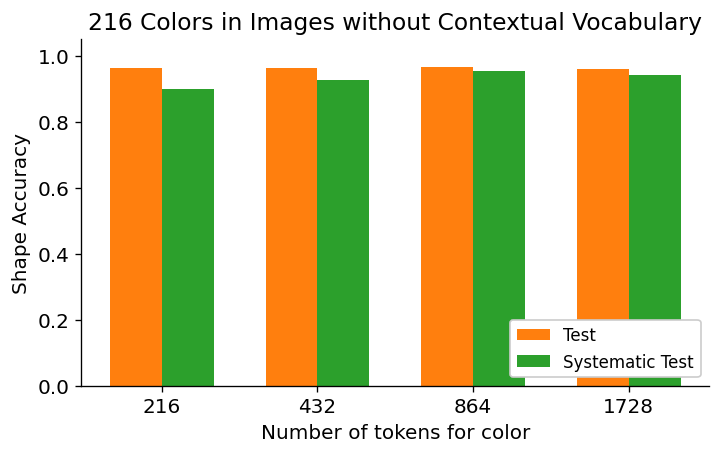

In [47]:
y_labels = ['Test', 'Systematic Test']
bar_colors = [test_color, syst_color]

multicolumn_barplot([shapes_test, shapes_syst],
                    xs,
                    y_labels,
                    title='216 Colors in Images without Contextual Vocabulary',
                    x_label='Number of tokens for color',
                    y_label='Shape Accuracy',
                    ylim=(0., 1.05),
                    legend_loc='lower right',
                    bar_colors=bar_colors,
                   )

# Show plot
plt.savefig(
    'exports/acc-shape-by-label-underloading-indep-216.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

## Contextual Underloading

In [48]:
[n for n in all_experiments.experiment_names if 'mmlm--n_colors=8c' in n]

['mmlm--n_colors=8c--d_hidden=128',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=192-indep',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=32-indep',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=64-no-indep',
 'mmlm--n_colors=8c--mlm_probability=0.15',
 'mmlm--n_colors=8c--d_hidden=32',
 'mmlm--n_colors=8c--d_hidden=64',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=32-no-indep',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=800-indep',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=800-no-indep',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=192-no-indep',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=96-no-indep',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=64-indep',
 'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=96-indep']

In [49]:
experiment_group = [
    'mmlm--n_colors=8c--mlm_probability=0.15',
    'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=192-no-indep',
    'mmlm--n_colors=8c--mlm_probability=0.15--overloading_to=800-no-indep',
]
xs = [8, 192, 800] 
# xs = [8, 16, 32, 64, 128, 256, 512] 

colors_test = all_experiments.read_exp_metric(experiment_group, 'color', 'test_acc')
colors_syst = all_experiments.read_exp_metric(experiment_group, 'color', 'systematic_test_acc')
# colors_cmn_syst = all_experiments.read_exp_metric(experiment_group, 'color', 'common_systematic_test_acc')

shapes_test = all_experiments.read_exp_metric(experiment_group, 'shapes', 'test_acc')
shapes_syst = all_experiments.read_exp_metric(experiment_group, 'shapes', 'systematic_test_acc')
# shapes_cmn_syst = all_experiments.read_exp_metric(experiment_group, 'shapes', 'common_systematic_test_acc')

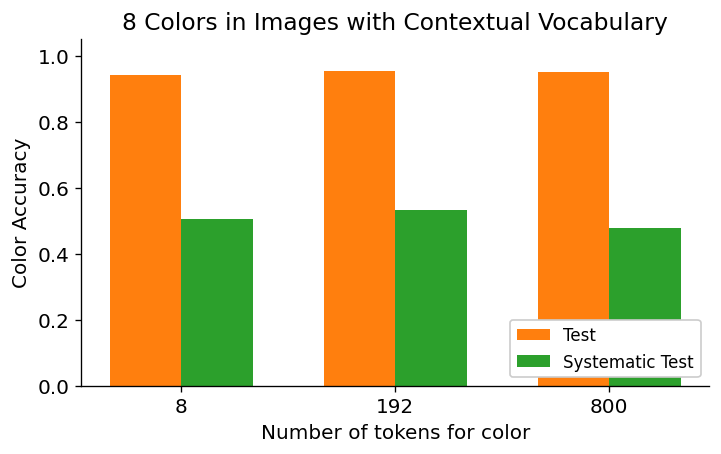

In [50]:
y_labels = ['Test', 'Systematic Test']
bar_colors = [test_color, syst_color]

multicolumn_barplot([colors_test, colors_syst],
                    xs,
                    y_labels,
                    title='8 Colors in Images with Contextual Vocabulary',
                    x_label='Number of tokens for color',
                    y_label='Color Accuracy',
                    ylim=(0., 1.05),
                    legend_loc='lower right',
                    bar_colors=bar_colors,
                   )

# Show plot
plt.savefig(
    'exports/acc-color-by-label-underloading-contextual-8.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

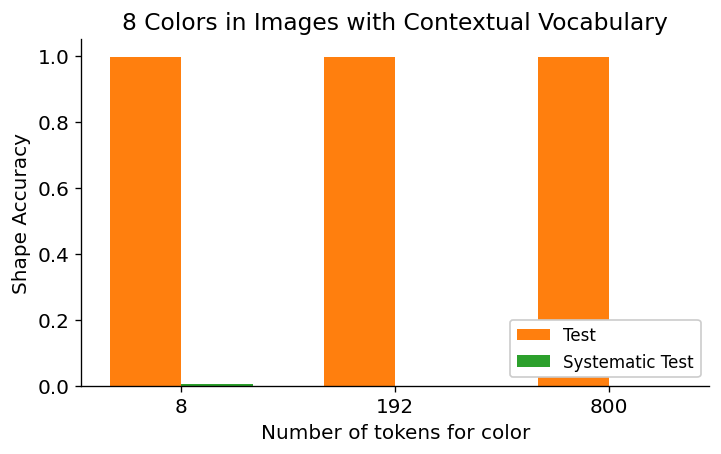

In [51]:
y_labels = ['Test', 'Systematic Test']
bar_colors = [test_color, syst_color]

multicolumn_barplot([shapes_test, shapes_syst],
                    xs,
                    y_labels,
                    title='8 Colors in Images with Contextual Vocabulary',
                    x_label='Number of tokens for color',
                    y_label='Shape Accuracy',
                    ylim=(0., 1.05),
                    legend_loc='lower right',
                    bar_colors=bar_colors,
                   )

# Show plot
plt.savefig(
    'exports/acc-shape-by-label-underloading-contextual-8.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [52]:
[n for n in all_experiments.experiment_names if 'mmlm--n_colors=64c' in n]

['mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=16',
 'mmlm--n_colors=64c--mlm_probability=0.15',
 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=32',
 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=8',
 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=128-no-indep',
 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=512-indep',
 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=128-indep',
 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=512-no-indep',
 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=256-indep',
 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=256-no-indep']

In [53]:
experiment_group = [
#     'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=8',
#     'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=16',
#     'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=32',
    'mmlm--n_colors=64c--mlm_probability=0.15',
    'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=128-no-indep',
    'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=256-no-indep',
    'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=512-no-indep',
]
xs = [64, 128, 256, 512] 
# xs = [8, 16, 32, 64, 128, 256, 512] 

colors_test = all_experiments.read_exp_metric(experiment_group, 'color', 'test_acc')
colors_syst = all_experiments.read_exp_metric(experiment_group, 'color', 'systematic_test_acc')
# colors_cmn_syst = all_experiments.read_exp_metric(experiment_group, 'color', 'common_systematic_test_acc')

shapes_test = all_experiments.read_exp_metric(experiment_group, 'shapes', 'test_acc')
shapes_syst = all_experiments.read_exp_metric(experiment_group, 'shapes', 'systematic_test_acc')
# shapes_cmn_syst = all_experiments.read_exp_metric(experiment_group, 'shapes', 'common_systematic_test_acc')

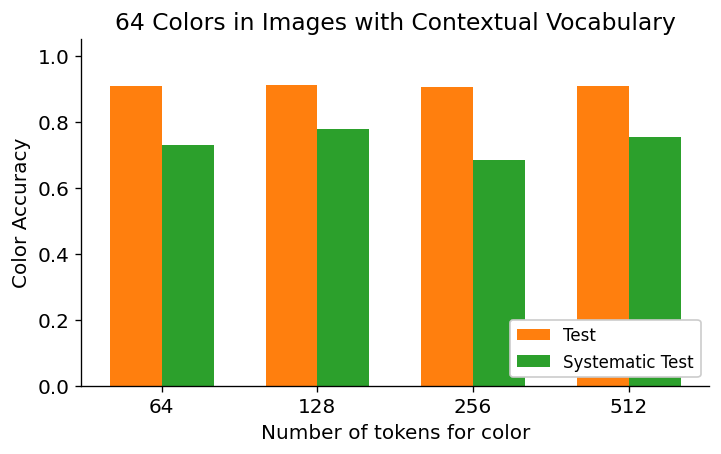

In [54]:
y_labels = ['Test', 'Systematic Test']
bar_colors = [test_color, syst_color]

multicolumn_barplot([colors_test, colors_syst],
                    xs,
                    y_labels,
                    title='64 Colors in Images with Contextual Vocabulary',
                    x_label='Number of tokens for color',
                    y_label='Color Accuracy',
                    ylim=(0., 1.05),
                    legend_loc='lower right',
                    bar_colors=bar_colors,
                   )

# Show plot
plt.savefig(
    'exports/acc-color-by-label-underloading-contextual-64.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

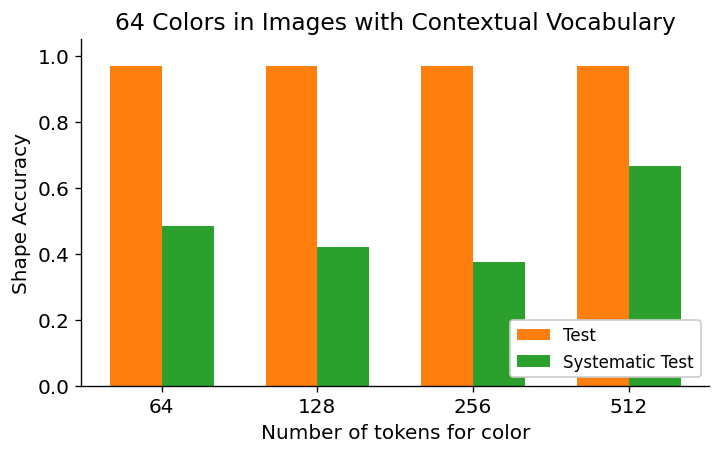

In [55]:
y_labels = ['Test', 'Systematic Test']
bar_colors = [test_color, syst_color]

multicolumn_barplot([shapes_test, shapes_syst],
                    xs,
                    y_labels,
                    title='64 Colors in Images with Contextual Vocabulary',
                    x_label='Number of tokens for color',
                    y_label='Shape Accuracy',
                    ylim=(0., 1.05),
                    legend_loc='lower right',
                    bar_colors=bar_colors,
                   )

# Show plot
plt.savefig(
    'exports/acc-shape-by-label-underloading-contextual-64.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [56]:
[n for n in all_experiments.experiment_names if 'mmlm--n_colors=216c' in n]

['mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=27',
 'mmlm--n_colors=216c--mlm_probability=0.15',
 'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=1728-indep',
 'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=864-no-indep',
 'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=1728-no-indep',
 'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=8',
 'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=432-indep',
 'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=864-indep',
 'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=54',
 'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=108']

In [57]:
experiment_group = [
#     'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=8',
#     'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=27',
#     'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=54',
#     'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=108',
    'mmlm--n_colors=216c--mlm_probability=0.15',
    'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=864-no-indep',
    'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=1728-no-indep',
]
xs = [216, 864, 1728]
# xs = [8, 27, 54, 108, 216, 864, 1728]

colors_test = all_experiments.read_exp_metric(experiment_group, 'color', 'test_acc')
colors_syst = all_experiments.read_exp_metric(experiment_group, 'color', 'systematic_test_acc')
# colors_cmn_syst = all_experiments.read_exp_metric(experiment_group, 'color', 'common_systematic_test_acc')

shapes_test = all_experiments.read_exp_metric(experiment_group, 'shapes', 'test_acc')
shapes_syst = all_experiments.read_exp_metric(experiment_group, 'shapes', 'systematic_test_acc')
# shapes_cmn_syst = all_experiments.read_exp_metric(experiment_group, 'shapes', 'common_systematic_test_acc')

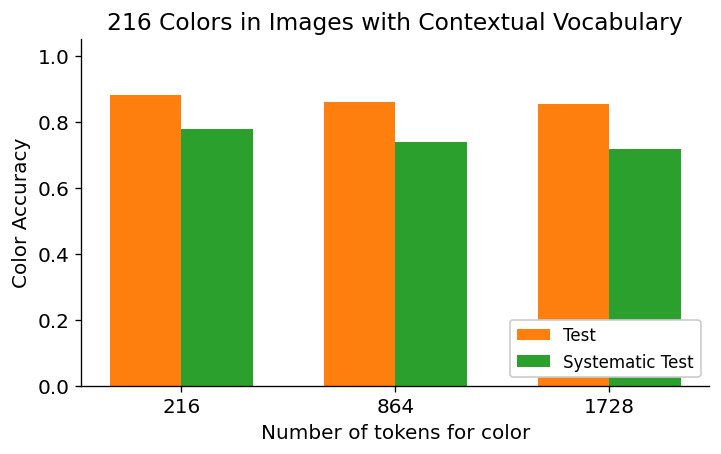

In [58]:
y_labels = ['Test', 'Systematic Test']
bar_colors = [test_color, syst_color]

multicolumn_barplot([colors_test, colors_syst],
                    xs,
                    y_labels,
                    title='216 Colors in Images with Contextual Vocabulary',
                    x_label='Number of tokens for color',
                    y_label='Color Accuracy',
                    ylim=(0., 1.05),
                    legend_loc='lower right',
                    bar_colors=bar_colors,
                   )

# Show plot
plt.savefig(
    'exports/acc-color-by-label-underloading-contextual-216.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

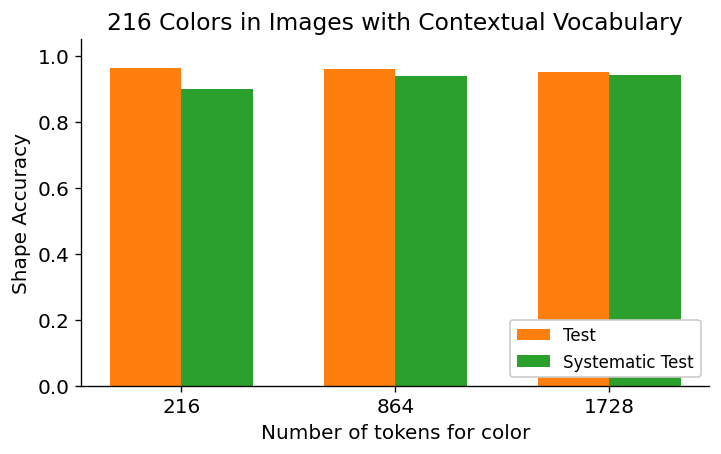

In [59]:
y_labels = ['Test', 'Systematic Test']
bar_colors = [test_color, syst_color]

multicolumn_barplot([shapes_test, shapes_syst],
                    xs,
                    y_labels,
                    title='216 Colors in Images with Contextual Vocabulary',
                    x_label='Number of tokens for color',
                    y_label='Shape Accuracy',
                    ylim=(0., 1.05),
                    legend_loc='lower right',
                    bar_colors=bar_colors,
                   )

# Show plot
plt.savefig(
    'exports/acc-shape-by-label-underloading-contextual-216.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

## Smaller Models on 8 Colors

In [60]:
experiment_group = [
     'mmlm--n_colors=8c--d_hidden=32',
     'mmlm--n_colors=8c--d_hidden=64',
     'mmlm--n_colors=8c--d_hidden=128',
     'mmlm--n_colors=8c--mlm_probability=0.15',
]
xs = [32, 64, 128, 256]
# xs = [8, 27, 54, 108, 216, 864, 1728]

colors_test, colors_test_err = all_experiments.read_exp_metric(experiment_group, 'color', 'test_acc', return_err=True)
colors_syst, colors_syst_err = all_experiments.read_exp_metric(experiment_group, 'color', 'systematic_test_acc', return_err=True)
# colors_cmn_syst = all_experiments.read_exp_metric(experiment_group, 'color', 'common_systematic_test_acc')

shapes_test, shapes_test_err = all_experiments.read_exp_metric(experiment_group, 'shapes', 'test_acc', return_err=True)
shapes_syst, shapes_syst_err = all_experiments.read_exp_metric(experiment_group, 'shapes', 'systematic_test_acc', return_err=True)
# shapes_cmn_syst = all_experiments.read_exp_metric(experiment_group, 'shapes', 'common_systematic_test_acc')

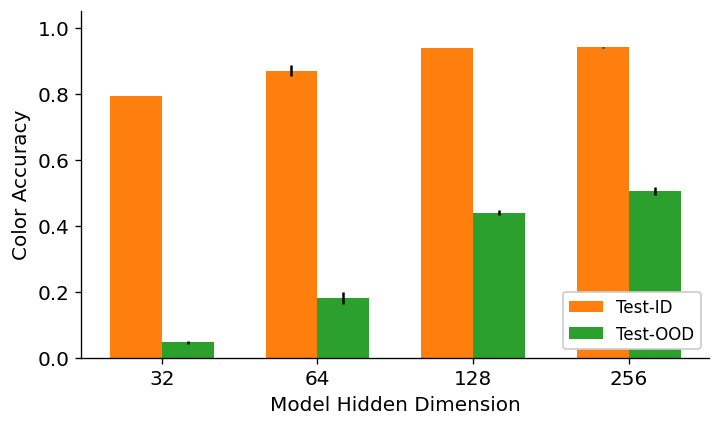

In [61]:
y_labels = ['Test-ID', 'Test-OOD']
bar_colors = [test_color, syst_color]

multicolumn_barplot([colors_test, colors_syst],
                    xs,
                    y_labels,
#                     title='Reduced Model Dimension (8 Colors)',
                    x_label='Model Hidden Dimension',
                    y_label='Color Accuracy',
                    ylim=(0., 1.05),
                    y_groups_errors=[colors_test_err,colors_syst_err],
                    legend_loc='lower right',
                    bar_colors=bar_colors,
                   )

# Show plot
plt.savefig(
    'exports/acc-color-smaller-models.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

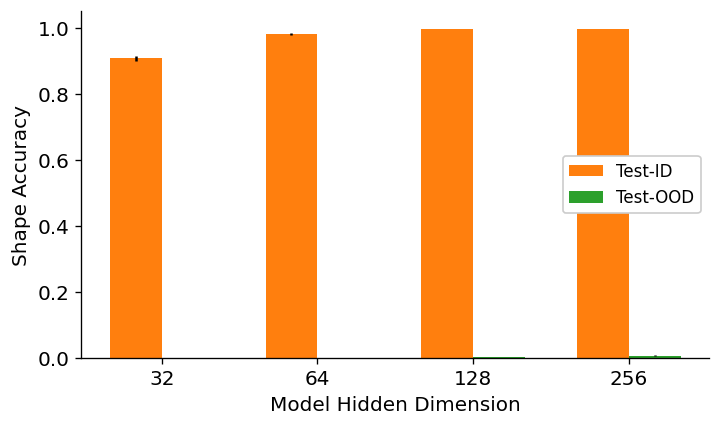

In [62]:
y_labels = ['Test-ID', 'Test-OOD']
bar_colors = [test_color, syst_color]

multicolumn_barplot([shapes_test, shapes_syst],
                    xs,
                    y_labels,
#                     title='Reduced Model Dimension (8 Colors)',
                    x_label='Model Hidden Dimension',
                    y_label='Shape Accuracy',
                    ylim=(0., 1.05),
                    y_groups_errors=[shapes_test_err,shapes_syst_err],
                    legend_loc='center right',
                    bar_colors=bar_colors,
                   )

# Show plot
plt.savefig(
    'exports/acc-shape-smaller-models.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

## Common colors

In [63]:
[n for n in all_experiments.experiment_names if 'mmlm--n_colors=216' in n]

['mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=27',
 'mmlm--n_colors=216c--mlm_probability=0.15',
 'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=1728-indep',
 'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=864-no-indep',
 'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=1728-no-indep',
 'mmlm--n_colors=216d1--mlm_probability=0.15',
 'mmlm--n_colors=216d2--mlm_probability=0.15',
 'mmlm--n_colors=216d3--mlm_probability=0.15',
 'mmlm--n_colors=216d4--mlm_probability=0.15',
 'mmlm--n_colors=216d2--mlm_probability=0.15--sim-cvlearning',
 'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=8',
 'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=432-indep',
 'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=864-indep',
 'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=54',
 'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=108']

In [64]:
# !ls /mnt/ialabnas/homes/fidelrio/clevr-dataset-gen/image_generation/data/multicolored-v2/

In [65]:
import json

color_types = {}
properties_dir = '/mnt/ialabnas/homes/fidelrio/clevr-dataset-gen/image_generation/data/multicolored-v2/'
splits = (
    ['8c', '64c', '216c']
    + [f'8e{i}' for i in range(1,4)]
    + [f'64e{i}' for i in range(1,5)]
    + [f'216d{i}' for i in range(1,5)]
)
# for split_file in Path(properties_dir).glob('CoGenT_A-[8c,8,216]*.json'):
#     with open(properties_dir + 'CoGenT_A-216d2.json') as fp:
for split in splits:
    split_file = Path(properties_dir + f'CoGenT_A-{split}.json')

    with split_file.open() as fp:
        color_dist = json.load(fp)
        
    color_signature = split_file.stem.replace('CoGenT_A-', '')

    all_colors = set(color_dist['sphere'])
    common_colors = set(color_dist['cube']) & set(color_dist['cylinder'])
    exclusive_colors = set(color_dist['cube']) - set(color_dist['cylinder'])
    
    color_types[color_signature] = {
        'common'   : len(common_colors),
        'exclusive': len(exclusive_colors),
    }

In [66]:
color_types

{'8c': {'common': 0, 'exclusive': 4},
 '64c': {'common': 48, 'exclusive': 8},
 '216c': {'common': 200, 'exclusive': 8},
 '8e1': {'common': 6, 'exclusive': 1},
 '8e2': {'common': 4, 'exclusive': 2},
 '8e3': {'common': 2, 'exclusive': 3},
 '64e1': {'common': 24, 'exclusive': 20},
 '64e2': {'common': 52, 'exclusive': 6},
 '64e3': {'common': 54, 'exclusive': 5},
 '64e4': {'common': 0, 'exclusive': 32},
 '216d1': {'common': 0, 'exclusive': 108},
 '216d2': {'common': 100, 'exclusive': 58},
 '216d3': {'common': 150, 'exclusive': 33},
 '216d4': {'common': 50, 'exclusive': 83}}

In [67]:
splits_to_plot = sorted([s for s in color_types if '216' in s], key=lambda s: color_types[s]['common'])
experiment_group = [f'mmlm--n_colors={s}--mlm_probability=0.15' for s in splits_to_plot]

x_label = 'Number of Common Colors'
xs = [color_types[s]['common'] for s in splits_to_plot]
# x_label = 'Number of Exclusice Colors'
# xs = [color_types[s]['exclusive'] for s in splits_to_plot]
# x_label = 'Common Colors / Exclusice Colors'
# xs = [color_types[s]['common'] / color_types[s]['exclusive'] for s in splits_to_plot]
# x_label = 'Proportion of Common Colors'
# xs = [color_types[s]['common'] / (color_types[s]['common'] + color_types[s]['exclusive']) for s in splits_to_plot]

colors_test, colors_test_err = all_experiments.read_exp_metric(experiment_group, 'color', 'test_acc', return_err=True)
colors_syst, colors_syst_err = all_experiments.read_exp_metric(experiment_group, 'color', 'systematic_test_acc', return_err=True)
# colors_cmn_syst = all_experiments.read_exp_metric(experiment_group, 'color', 'common_systematic_test_acc')

shapes_test, shapes_test_err = all_experiments.read_exp_metric(experiment_group, 'shapes', 'test_acc', return_err=True)
shapes_syst, shapes_syst_err = all_experiments.read_exp_metric(experiment_group, 'shapes', 'systematic_test_acc', return_err=True)
# shapes_cmn_syst = all_experiments.read_exp_metric(experiment_group, 'shapes', 'common_systematic_test_acc')

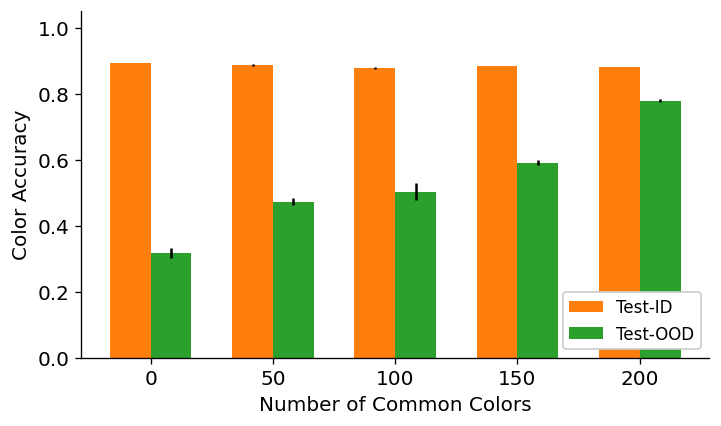

In [68]:
y_labels = ['Test-ID', 'Test-OOD']
bar_colors = [test_color, syst_color]

multicolumn_barplot([colors_test, colors_syst],
                    xs,
                    y_labels,
#                     title='216 Colors with Different Number of Common Colors',
                    x_label=x_label,
                    y_label='Color Accuracy',
                    ylim=(0., 1.05),
                    y_groups_errors=[colors_test_err,colors_syst_err],
                    legend_loc='lower right',
                    bar_colors=bar_colors,
                   )

# plt.gca().set_xticklabels(['{:,.2f}'.format(x) for x in xs])

# Show plot
plt.savefig(
    'exports/acc-colors-by-common-colors-216.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

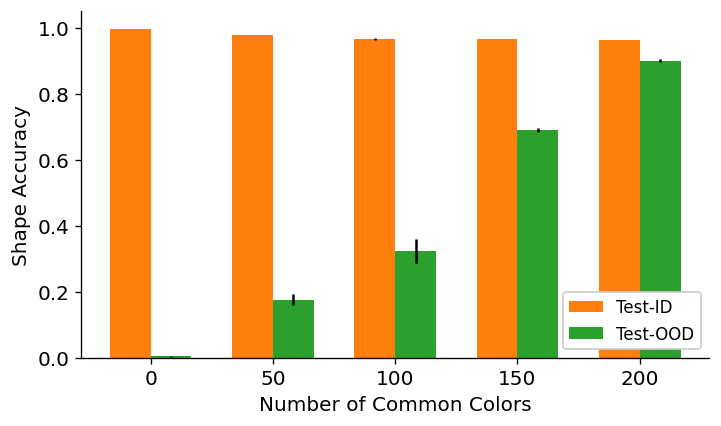

In [69]:
y_labels = ['Test-ID', 'Test-OOD']
bar_colors = [test_color, syst_color]

multicolumn_barplot([shapes_test, shapes_syst],
                    xs,
                    y_labels,
#                     title='216 Colors with Different Number of Common Colors',
                    x_label=x_label,
                    y_label='Shape Accuracy',
                    ylim=(0., 1.05),
                    y_groups_errors=[shapes_test_err,shapes_syst_err],
                    legend_loc='lower right',
                    bar_colors=bar_colors,
                   )

# plt.gca().set_xticklabels(['{:,.2f}'.format(x) for x in xs])

# Show plot
plt.savefig(
    'exports/acc-shapes-by-common-colors-216.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [70]:
# plt.scatter(np.log(xs)*100,shapes_syst)

In [71]:
splits_to_plot = sorted([s for s in color_types if '8' in s], key=lambda s: color_types[s]['common'])
splits_to_plot = ['8c', '8e3', '8e2', '8e1']
experiment_group = [f'mmlm--n_colors={s}--mlm_probability=0.15' for s in splits_to_plot]

x_label = 'Number of Common Colors'
xs = [color_types[s]['common'] for s in splits_to_plot]
# x_label = 'Number of Exclusice Colors'
# xs = [color_types[s]['exclusive'] for s in splits_to_plot]
# x_label = 'Common Colors / Exclusice Colors'
# xs = [color_types[s]['common'] / color_types[s]['exclusive'] for s in splits_to_plot]
# x_label = 'Proportion of Common Colors'
# xs = [color_types[s]['common'] / (color_types[s]['common'] + color_types[s]['exclusive']) for s in splits_to_plot]

colors_test, colors_test_err = all_experiments.read_exp_metric(experiment_group, 'color', 'test_acc', return_err=True)
colors_syst, colors_syst_err = all_experiments.read_exp_metric(experiment_group, 'color', 'systematic_test_acc', return_err=True)
# colors_cmn_syst = all_experiments.read_exp_metric(experiment_group, 'color', 'common_systematic_test_acc')

shapes_test, shapes_test_err = all_experiments.read_exp_metric(experiment_group, 'shapes', 'test_acc', return_err=True)
shapes_syst, shapes_syst_err = all_experiments.read_exp_metric(experiment_group, 'shapes', 'systematic_test_acc', return_err=True)
# shapes_cmn_syst = all_experiments.read_exp_metric(experiment_group, 'shapes', 'common_systematic_test_acc')

In [72]:
experiment_group, shapes_syst

(['mmlm--n_colors=8c--mlm_probability=0.15',
  'mmlm--n_colors=8e3--mlm_probability=0.15',
  'mmlm--n_colors=8e2--mlm_probability=0.15',
  'mmlm--n_colors=8e1--mlm_probability=0.15'],
 (0.006453334741915266,
  0.003068856351698438,
  0.006264829852928718,
  0.09050868451595306))

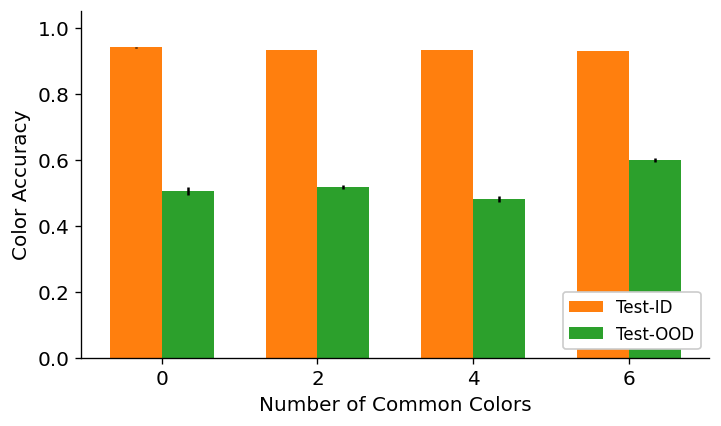

In [73]:
y_labels = ['Test-ID', 'Test-OOD']
bar_colors = [test_color, syst_color]

multicolumn_barplot([colors_test, colors_syst],
                    xs,
                    y_labels,
#                     title='216 Colors with Different Number of Common Colors',
                    x_label=x_label,
                    y_label='Color Accuracy',
                    ylim=(0., 1.05),
                    y_groups_errors=[colors_test_err,colors_syst_err],
                    legend_loc='lower right',
                    bar_colors=bar_colors,
                   )

# plt.gca().set_xticklabels(['{:,.2f}'.format(x) for x in xs])

# Show plot
plt.savefig(
    'exports/acc-colors-by-common-colors-8.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

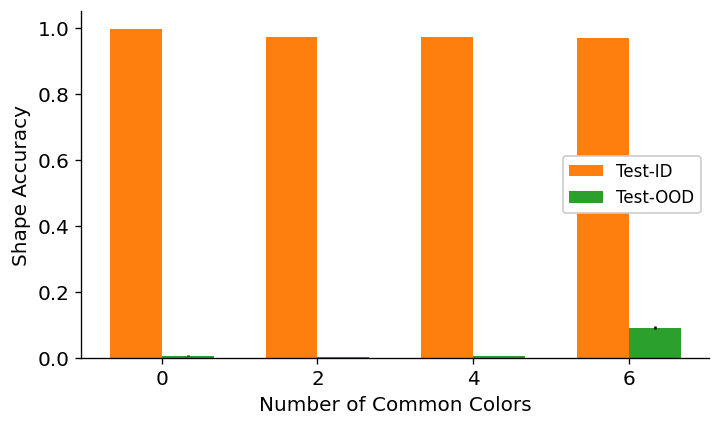

In [74]:
y_labels = ['Test-ID', 'Test-OOD']
bar_colors = [test_color, syst_color]

multicolumn_barplot([shapes_test, shapes_syst],
                    xs,
                    y_labels,
#                     title='216 Colors with Different Number of Common Colors',
                    x_label=x_label,
                    y_label='Shape Accuracy',
                    ylim=(0., 1.05),
                    y_groups_errors=[shapes_test_err,shapes_syst_err],
                    legend_loc='center right',
                    bar_colors=bar_colors,
                   )

# plt.gca().set_xticklabels(['{:,.2f}'.format(x) for x in xs])

# Show plot
plt.savefig(
    'exports/acc-shapes-by-common-colors-8.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [75]:
# plt.scatter(np.log(xs),shapes_syst)

## NMI

In [76]:
all_experiments.get_exp(all_experiments.experiment_names[0]).runs[0].results['nmi_scores']['color:shape']

0.001628899329623211

In [77]:
all_nmi_scores = {
    en: all_experiments.get_exp(en).runs[0].results['nmi_scores']
    for en in all_experiments.experiment_names
}

In [78]:
filter_to_overloading = lambda en: '--overloading' in en and not 'indep' in en
filter_to_underloading = lambda en: '--overloading' in en and 'indep' in en
filter_to_underloading_indep = lambda en: '--overloading' in en and 'indep' in en and 'no-indep' not in en
filter_to_underloading_no_indep = lambda en: '--overloading' in en and 'indep' in en and 'no-indep' in en
filter_to_capacity = lambda en: '--d_hidden' in en
filter_to_base = lambda en: '--overloading' not in en and '--d_hidden' not in en and 'sim-cvlearning' not in en
filter_to_num = lambda en, num: f'n_colors={num}' in en if num else True

overloading_exps = [en for en in all_experiments.experiment_names if '--overloading' in en]
capacity_exps = [en for en in all_experiments.experiment_names if '--d_hidden' in en]
base_exps = list(set(all_experiments.experiment_names) - set(overloading_exps) - set(capacity_exps))

by_ncolors_exps = {num: 
    [en for en in all_experiments.experiment_names if f'n_colors={num}' in en] for num in [8, 27, 64, 125, 216]}

is_valid = lambda en: en in all_nmi_scores and 'color:shape' in all_nmi_scores[en]

In [79]:
def get_scatter_info_from(exps):
    test_accs = all_experiments.read_exp_metric(exps, 'shapes', 'test_acc')
    syst_accs = all_experiments.read_exp_metric(exps, 'shapes', 'systematic_test_acc')
    shape_color_nmis = [all_nmi_scores[en]['color:shape'] for en in exps]
    return shape_color_nmis, test_accs, syst_accs

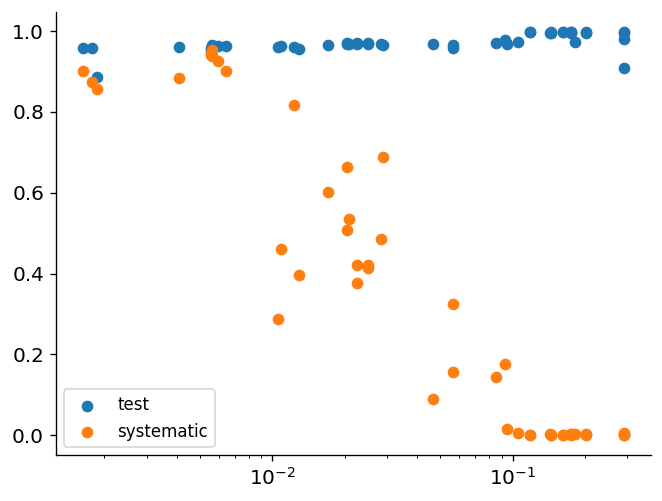

In [80]:
nmi_exps = [en for en in all_experiments.experiment_names if is_valid(en)]
shape_color_nmis, test_accs, syst_accs = get_scatter_info_from(nmi_exps)

plt.scatter(shape_color_nmis, test_accs, label='test')
plt.scatter(shape_color_nmis, syst_accs, label='systematic')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()

In [81]:
color_types

{'8c': {'common': 0, 'exclusive': 4},
 '64c': {'common': 48, 'exclusive': 8},
 '216c': {'common': 200, 'exclusive': 8},
 '8e1': {'common': 6, 'exclusive': 1},
 '8e2': {'common': 4, 'exclusive': 2},
 '8e3': {'common': 2, 'exclusive': 3},
 '64e1': {'common': 24, 'exclusive': 20},
 '64e2': {'common': 52, 'exclusive': 6},
 '64e3': {'common': 54, 'exclusive': 5},
 '64e4': {'common': 0, 'exclusive': 32},
 '216d1': {'common': 0, 'exclusive': 108},
 '216d2': {'common': 100, 'exclusive': 58},
 '216d3': {'common': 150, 'exclusive': 33},
 '216d4': {'common': 50, 'exclusive': 83}}

In [82]:
to_color_num = lambda c: f"{c.split('c')[0].split('d')[0].split('e')[0]}"
color_names = {name: f"{to_color_num(name)} cmn={types_['common']}" for name, types_ in color_types.items()}

In [83]:
color_names = {
    '27c': '27 cmn=0',
    '125c': '125 cmn=0',
    **color_names}

In [84]:
color_names

{'27c': '27 cmn=0',
 '125c': '125 cmn=0',
 '8c': '8 cmn=0',
 '64c': '64 cmn=48',
 '216c': '216 cmn=200',
 '8e1': '8 cmn=6',
 '8e2': '8 cmn=4',
 '8e3': '8 cmn=2',
 '64e1': '64 cmn=24',
 '64e2': '64 cmn=52',
 '64e3': '64 cmn=54',
 '64e4': '64 cmn=0',
 '216d1': '216 cmn=0',
 '216d2': '216 cmn=100',
 '216d3': '216 cmn=150',
 '216d4': '216 cmn=50'}

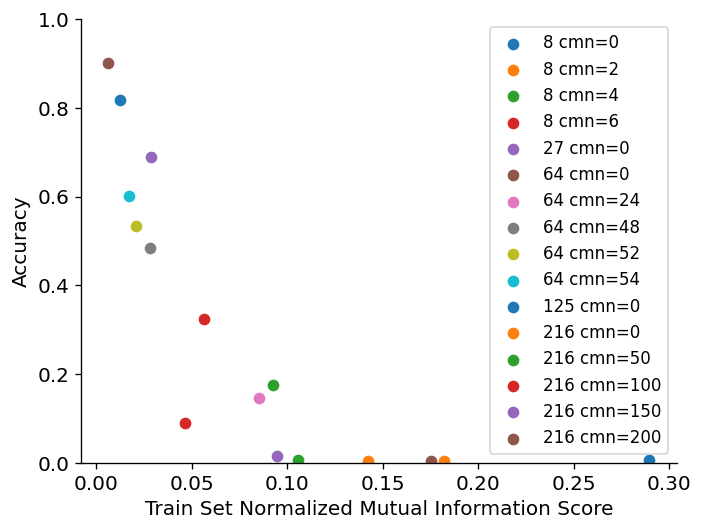

In [85]:
num_colors = 0

# by_nmi = lambda en: get_scatter_info_from([en])[0][0]
by_nmi = lambda en: (int(color_names[en.split('n_colors=')[-1].split('--')[0]].split()[0]),
                     color_types.get(en.split('n_colors=')[-1].split('--')[0],{'common':0})['common'])
nmi_exps = sorted([en for en in all_experiments.experiment_names
                    if is_valid(en) and filter_to_num(en, num_colors) and filter_to_base(en)],
                  key=by_nmi)
# nmi_exps = [en for en in all_experiments.experiment_names
#                     if is_valid(en) and filter_to_num(en, num_colors) and filter_to_base(en)]
min_nmi = float('inf')
max_nmi = float('-inf')
for en in nmi_exps:
    label = color_names[en.split('n_colors=')[-1].split('--')[0]]
    shape_color_nmis, test_accs, syst_accs = get_scatter_info_from([en])
    plt.scatter(shape_color_nmis, syst_accs, label=label)

    min_nmi = min(min_nmi, shape_color_nmis[0])
    max_nmi = max(max_nmi, shape_color_nmis[0])

# shape_color_nmis, test_accs, syst_accs = get_catter_info_from(nmi_exps)
# plt.scatter(shape_color_nmis, syst_accs, label='base')


# plt.hlines(y=1/3, xmin=min_nmi, xmax=max_nmi, linestyles='--', lw=1, label='Random') # color='red'

# plt.xscale('log')
# plt.yscale('log')
plt.ylabel('Accuracy')
plt.xlabel('Train Set Normalized Mutual Information Score')
plt.ylim(0,1)
plt.legend()
plt.savefig(
    'exports/nmi-vs-accuracy-all-labels.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

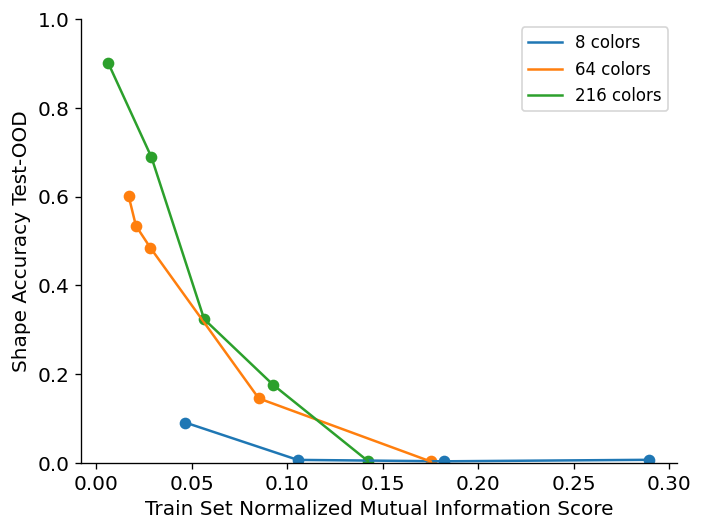

In [86]:
num_colors = 0
all_num_colors = [8, 27, 64, 125, 216]

# by_nmi = lambda en: get_scatter_info_from([en])[0][0]
by_nmi = lambda en: (int(color_names[en.split('n_colors=')[-1].split('--')[0]].split()[0]),
                     color_types.get(en.split('n_colors=')[-1].split('--')[0],{'common':0})['common'])
nmi_exps = [sorted([en for en in all_experiments.experiment_names
                    if is_valid(en) and filter_to_num(en, num_colors) and filter_to_base(en)],
                  key=by_nmi) for num_colors in all_num_colors]
# nmi_exps = [en for en in all_experiments.experiment_names
#                     if is_valid(en) and filter_to_num(en, num_colors) and filter_to_base(en)]
min_nmi = float('inf')
max_nmi = float('-inf')
for en, num_colors in zip(nmi_exps, all_num_colors):
    label = f'{num_colors} colors'
    
    shape_color_nmis, test_accs, syst_accs = get_scatter_info_from(en)
    if len(shape_color_nmis) <= 1:
        continue

    plt.scatter(shape_color_nmis, syst_accs)
    plt.plot(shape_color_nmis, syst_accs, label=label)

    min_nmi = min(min_nmi, shape_color_nmis[0])
    max_nmi = max(max_nmi, shape_color_nmis[0])

# shape_color_nmis, test_accs, syst_accs = get_catter_info_from(nmi_exps)
# plt.scatter(shape_color_nmis, syst_accs, label='base')


# plt.hlines(y=1/3, xmin=min_nmi, xmax=max_nmi, linestyles='--', lw=1, label='Random') # color='red'

# plt.xscale('log')
# plt.yscale('log')
plt.ylabel('Shape Accuracy Test-OOD')
plt.xlabel('Train Set Normalized Mutual Information Score')
plt.ylim(0,1)
plt.legend()
plt.savefig(
    'exports/nmi-vs-accuracy.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [87]:
min(shape_color_nmis), max(shape_color_nmis)

(0.006433010031061052, 0.14229444131712884)

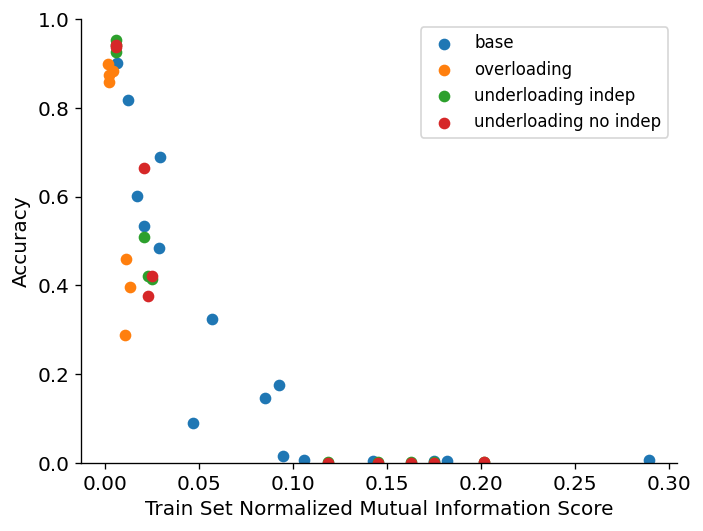

In [88]:
num_colors = 0

nmi_exps = [en for en in all_experiments.experiment_names
            if is_valid(en) and filter_to_num(en, num_colors) and filter_to_base(en)]
shape_color_nmis, test_accs, syst_accs = get_scatter_info_from(nmi_exps)
plt.scatter(shape_color_nmis, syst_accs, label='base')

nmi_exps = [en for en in all_experiments.experiment_names
            if is_valid(en) and filter_to_num(en, num_colors) and filter_to_overloading(en)]
shape_color_nmis, test_accs, syst_accs = get_scatter_info_from(nmi_exps)
plt.scatter(shape_color_nmis, syst_accs, label='overloading')

nmi_exps = [en for en in all_experiments.experiment_names
            if is_valid(en) and filter_to_num(en, num_colors) and filter_to_underloading_indep(en)]
shape_color_nmis, test_accs, syst_accs = get_scatter_info_from(nmi_exps)
plt.scatter(shape_color_nmis, syst_accs, label='underloading indep')

nmi_exps = [en for en in all_experiments.experiment_names
            if is_valid(en) and filter_to_num(en, num_colors) and filter_to_underloading_no_indep(en)]
shape_color_nmis, test_accs, syst_accs = get_scatter_info_from(nmi_exps)
plt.scatter(shape_color_nmis, syst_accs, label='underloading no indep')

# plt.xscale('log')
# plt.yscale('log')
plt.ylabel('Accuracy')
plt.xlabel('Train Set Normalized Mutual Information Score')
plt.legend()
plt.ylim(0,1)
plt.show()

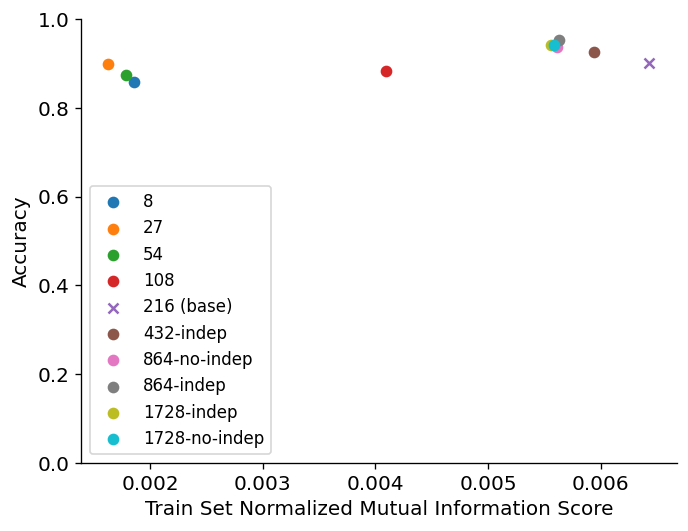

In [89]:
num_colors = 216

overloading_value = lambda en: int(en.split('=')[-1].split('-')[0])

overloading_nmis = sorted([en for en in all_experiments.experiment_names
                           if is_valid(en) and filter_to_num(en, num_colors) and filter_to_overloading(en)],
                          key=overloading_value)

for en in overloading_nmis:
    label = str(en.split('=')[-1])
    shape_color_nmis, test_accs, syst_accs = get_scatter_info_from([en])
    plt.scatter(shape_color_nmis, syst_accs, label=label)
    

    
nmi_exps = [f'mmlm--n_colors={num_colors}c--mlm_probability=0.15']
shape_color_nmis, test_accs, syst_accs = get_scatter_info_from(nmi_exps)
plt.scatter(shape_color_nmis, syst_accs, label=f'{num_colors} (base)', marker='x')


underloading_nmis = sorted([en for en in all_experiments.experiment_names
                            if is_valid(en) and filter_to_num(en, num_colors) and filter_to_underloading(en)],
                           key=overloading_value)

for en in underloading_nmis:
    label = str(en.split('=')[-1])
    shape_color_nmis, test_accs, syst_accs = get_scatter_info_from([en])
    plt.scatter(shape_color_nmis, syst_accs, label=label) 


# plt.xscale('log')
# plt.yscale('log')
plt.ylabel('Accuracy')
plt.xlabel('Train Set Normalized Mutual Information Score')
plt.ylim(0,1)
plt.legend()
plt.show()

## P-Scores

In [90]:
p_score_metric = 'p_scores_within_task'

In [91]:
# all_experiments.get_exp(all_experiments.experiment_names[0]).runs[0].results[p_score_metric]

In [92]:
from collections import defaultdict

def merge_p_scores(all_p_scores):
    merged_p_scores = {}
    for k0 in all_p_scores[0]:
        merged_p_scores[k0] = defaultdict(list)
        for k1 in all_p_scores[0][k0]:
            for p_scores in all_p_scores:
                merged_p_scores[k0][k1].extend(p_scores[k0][k1])
        merged_p_scores[k0] = dict(merged_p_scores[k0])
    return merged_p_scores
            

all_p_scores = {
    en: merge_p_scores(
        [run.results[p_score_metric] for run in all_experiments.get_exp(en).runs if p_score_metric in run.results])
    for en in all_experiments.experiment_names
    if any(p_score_metric in r.results for r in all_experiments.get_exp(en).runs)
}

In [93]:
list(all_p_scores.keys())

['mmlm--n_colors=125c--mlm_probability=0.15',
 'mmlm--n_colors=216c--mlm_probability=0.15',
 'mmlm--n_colors=64c--mlm_probability=0.15',
 'mmlm--n_colors=8c--d_hidden=128',
 'mmlm--n_colors=8c--mlm_probability=0.15',
 'mmlm--n_colors=27c--mlm_probability=0.15',
 'mmlm--n_colors=216d1--mlm_probability=0.15',
 'mmlm--n_colors=216d2--mlm_probability=0.15',
 'mmlm--n_colors=216d3--mlm_probability=0.15',
 'mmlm--n_colors=216d4--mlm_probability=0.15',
 'mmlm--n_colors=8e2--mlm_probability=0.15',
 'mmlm--n_colors=216d2--mlm_probability=0.15--sim-cvlearning',
 'mmlm--n_colors=8c--d_hidden=32',
 'mmlm--n_colors=8c--d_hidden=64',
 'mmlm--n_colors=8e3--mlm_probability=0.15',
 'mmlm--n_colors=64e1--mlm_probability=0.15',
 'mmlm--n_colors=64e2--mlm_probability=0.15',
 'mmlm--n_colors=8e1--mlm_probability=0.15',
 'mmlm--n_colors=64e3--mlm_probability=0.15',
 'mmlm--n_colors=64e4--mlm_probability=0.15']

In [94]:
filter_to_overloading = lambda en: '--overloading' in en and not 'indep' in en
filter_to_underloading = lambda en: '--overloading' in en and 'indep' in en
filter_to_underloading_indep = lambda en: '--overloading' in en and 'indep' in en and 'no-indep' not in en
filter_to_underloading_no_indep = lambda en: '--overloading' in en and 'indep' in en and 'no-indep' in en
filter_to_capacity = lambda en: '--d_hidden' in en
filter_to_base = lambda en: '--overloading' not in en and '--d_hidden' not in en and 'sim-cvlearning' not in en
filter_to_num = lambda en, num: f'n_colors={num}' in en if num else True

overloading_exps = [en for en in all_experiments.experiment_names if '--overloading' in en]
capacity_exps = [en for en in all_experiments.experiment_names if '--d_hidden' in en]
base_exps = list(set(all_experiments.experiment_names) - set(overloading_exps) - set(capacity_exps))

by_ncolors_exps = {num: 
    [en for en in all_experiments.experiment_names if f'n_colors={num}' in en] for num in [8, 27, 64, 125, 216]}

is_valid = lambda en: en in all_p_scores# and 'color:shape' in all_nmi_scores[en]

In [95]:
# def get_scatter_info_from(exps):
#     test_accs = all_experiments.read_exp_metric(exps, 'shapes', 'test_acc')
#     syst_accs = all_experiments.read_exp_metric(exps, 'shapes', 'systematic_test_acc')
#     p_scores = [all_p_scores[en]['p_scores'] for en in exps]
#     return p_scores, test_accs, syst_accs

In [96]:
split = 'complete'
task = 'colors'
acc_task_metric = 'color'

valid_p_score_exp = lambda n: 'overloading_to=8.json' in n or 'overloading' not in n

exp_names = sorted([exp_name for exp_name in all_p_scores if valid_p_score_exp(exp_name)])

exp_names_by_num_colors = [sorted([en for en in all_experiments.experiment_names
                                   if is_valid(en) and filter_to_num(en, num_colors) and filter_to_base(en)],
                                   key=by_nmi) for num_colors in all_num_colors]


exp_names = [exp_name for exp_names in exp_names_by_num_colors for exp_name in exp_names]
# p_scores = [all_p_scores[exp_name][split][task] for exp_names in exp_names for exp_name in exp_names]

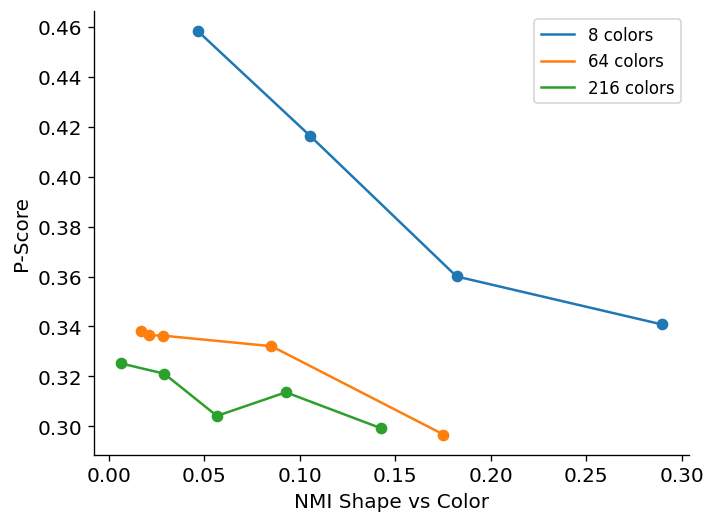

In [97]:
for exps, num_colors in zip(exp_names_by_num_colors, all_num_colors):
    label = f'{num_colors} colors'
    if len(exps) <= 1:
        continue

    p_scores = np.array([np.mean(all_p_scores[en][split][task]) for en in exps])
    p_scores_err = np.array([np.std(all_p_scores[en][split][task]) for en in exps]) / np.sqrt(len(exps))
    shape_color_nmis = [all_nmi_scores[en]['color:shape'] for en in exps]
    syst_accs = all_experiments.read_exp_metric(exps, acc_task_metric, 'systematic_test_acc')
    
    
    plt.scatter(shape_color_nmis, p_scores)
    plot = plt.plot(shape_color_nmis, p_scores, label=label)
#     plt.fill_between(shape_color_nmis, p_scores-p_scores_err, p_scores+p_scores_err, color=plot[0].get_color())
    plt.ylabel('P-Score')
    plt.xlabel('NMI Shape vs Color')
    
# plt.ylim(0,1)
plt.legend()
plt.savefig(
    f'exports/nmi-vs-p-score-{split}-{task}.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

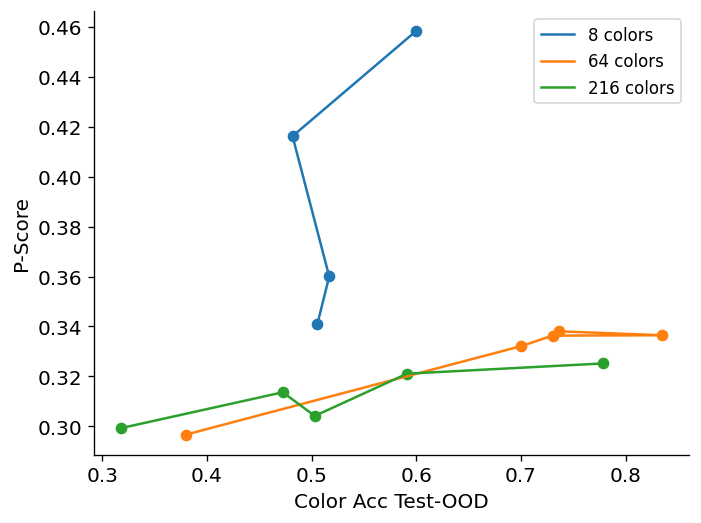

In [98]:
for exps, num_colors in zip(exp_names_by_num_colors, all_num_colors):
    if len(exps) <= 1:
        continue
        
    label = f'{num_colors} colors'
    
    p_scores = np.array([np.mean(all_p_scores[en][split][task]) for en in exps])
    p_scores_err = np.array([np.std(all_p_scores[en][split][task]) for en in exps]) / np.sqrt(len(exps))
    shape_color_nmis = [all_nmi_scores[en]['color:shape'] for en in exps]
    syst_accs = all_experiments.read_exp_metric(exps, acc_task_metric, 'systematic_test_acc')
    
    plt.scatter(syst_accs, p_scores)
    plot = plt.plot(syst_accs, p_scores, label=label)
#     plt.fill_between(syst_accs, p_scores-p_scores_err, p_scores+p_scores_err, color=plot[0].get_color())
    plt.xlabel(f'{acc_task_metric.capitalize()} Acc Test-OOD')
    plt.ylabel('P-Score')
    
# plt.ylim(0,1)
plt.legend()
plt.savefig(
    f'exports/acc-{acc_task_metric}-vs-p-score-in-{split}-for-{task}.pdf',
    format='pdf', dpi=300, bbox_inches='tight')
plt.show()

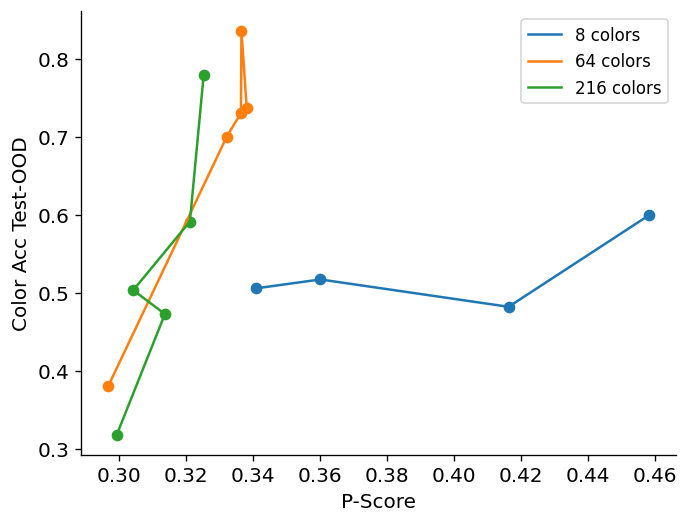

In [99]:
for exps, num_colors in zip(exp_names_by_num_colors, all_num_colors):
    if len(exps) <= 1:
        continue
        
    label = f'{num_colors} colors'
    
    p_scores = np.array([np.mean(all_p_scores[en][split][task]) for en in exps])
    p_scores_err = np.array([np.std(all_p_scores[en][split][task]) for en in exps]) / np.sqrt(len(exps))
    shape_color_nmis = [all_nmi_scores[en]['color:shape'] for en in exps]
    syst_accs, syst_accs_err = all_experiments.read_exp_metric(
        exps, acc_task_metric, 'systematic_test_acc', return_err=True)
    syst_accs, syst_accs_err = np.array(syst_accs), np.array(syst_accs_err)
    
    plt.scatter(p_scores, syst_accs)
    plot = plt.plot(p_scores, syst_accs, label=label)
#     plt.fill_between(p_scores, syst_accs-syst_accs_err, syst_accs+syst_accs_err, color=plot[0].get_color())
    plt.ylabel(f'{acc_task_metric.capitalize()} Acc Test-OOD')
    plt.xlabel('P-Score')
    
# plt.ylim(0,1)
plt.legend()
plt.savefig(
    f'exports/p-score-vs-acc-{acc_task_metric}-in-{split}-for-{task}.pdf',
    format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [100]:
split = 'complete'
task = 'shapes'
acc_task_metric = 'shapes'

valid_p_score_exp = lambda n: 'overloading_to=8.json' in n or 'overloading' not in n

exp_names = sorted([exp_name for exp_name in all_p_scores if valid_p_score_exp(exp_name)])

exp_names_by_num_colors = [sorted([en for en in all_experiments.experiment_names
                                   if is_valid(en) and filter_to_num(en, num_colors) and filter_to_base(en)],
                                   key=by_nmi) for num_colors in all_num_colors]


exp_names = [exp_name for exp_names in exp_names_by_num_colors for exp_name in exp_names]
# p_scores = [all_p_scores[exp_name][split][task] for exp_names in exp_names for exp_name in exp_names]

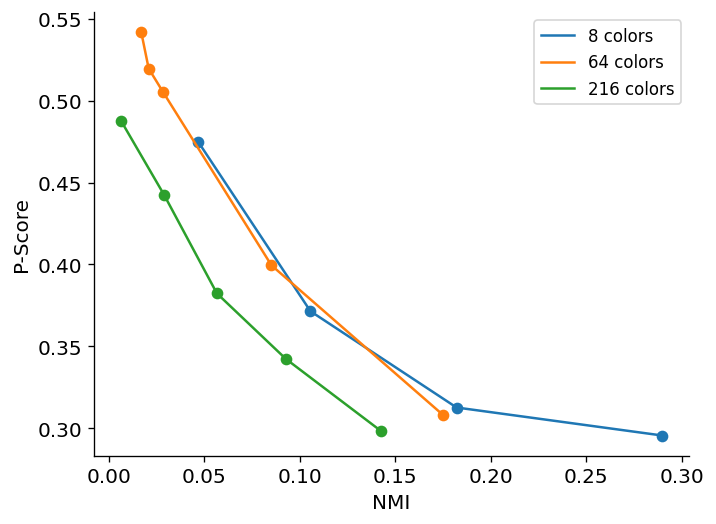

In [101]:
for exps, num_colors in zip(exp_names_by_num_colors, all_num_colors):
    label = f'{num_colors} colors'
    if len(exps) <= 1:
        continue

    p_scores = np.array([np.mean(all_p_scores[en][split][task]) for en in exps])
    p_scores_err = np.array([np.std(all_p_scores[en][split][task]) for en in exps]) / np.sqrt(len(exps))
    shape_color_nmis = [all_nmi_scores[en]['color:shape'] for en in exps]
    syst_accs = all_experiments.read_exp_metric(exps, acc_task_metric, 'systematic_test_acc')
    
    plt.scatter(shape_color_nmis, p_scores)
    plot = plt.plot(shape_color_nmis, p_scores, label=label)
#     plt.fill_between(shape_color_nmis, p_scores-p_scores_err, p_scores+p_scores_err, color=plot[0].get_color())
    plt.ylabel('P-Score')
    plt.xlabel('NMI')
    
# plt.ylim(0,1)
plt.legend()
plt.savefig(
    f'exports/nmi-vs-p-score-{split}-{task}.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

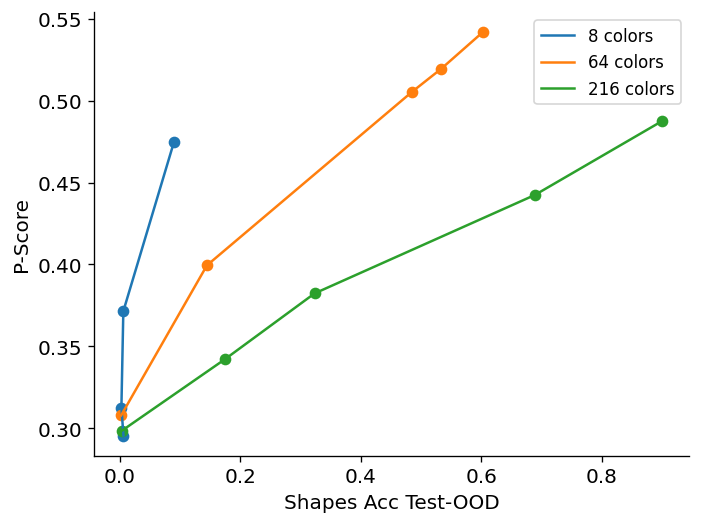

In [102]:
for exps, num_colors in zip(exp_names_by_num_colors, all_num_colors):
    if len(exps) <= 1:
        continue
        
    label = f'{num_colors} colors'
    
    p_scores = np.array([np.mean(all_p_scores[en][split][task]) for en in exps])
    p_scores_err = np.array([np.std(all_p_scores[en][split][task]) for en in exps]) / np.sqrt(len(exps))
    shape_color_nmis = [all_nmi_scores[en]['color:shape'] for en in exps]
    syst_accs = all_experiments.read_exp_metric(exps, acc_task_metric, 'systematic_test_acc')

    plt.scatter(syst_accs, p_scores)
    plot = plt.plot(syst_accs, p_scores, label=label)
#     plt.fill_between(syst_accs, p_scores-p_scores_err, p_scores+p_scores_err, color=plot[0].get_color())
    plt.xlabel(f'{acc_task_metric.capitalize()} Acc Test-OOD')
    plt.ylabel('P-Score')
    
# plt.ylim(0,1)
plt.legend()
plt.savefig(
    f'exports/acc-{acc_task_metric}-vs-p-score-in-{split}-for-{task}.pdf',
    format='pdf', dpi=300, bbox_inches='tight')
plt.show()

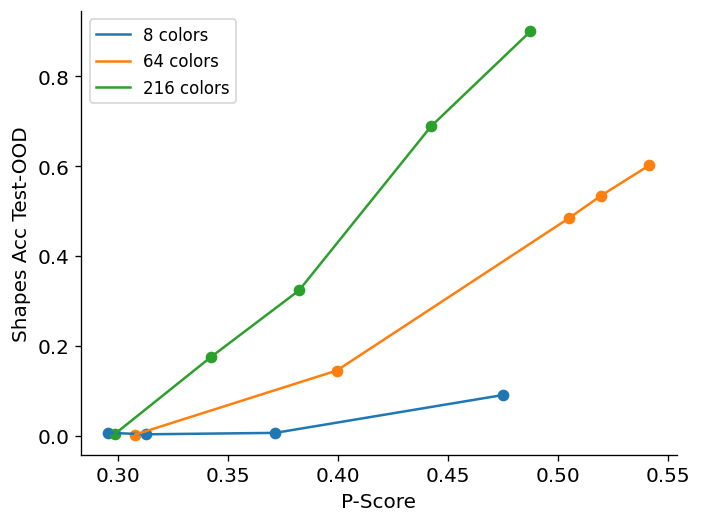

In [103]:
for exps, num_colors in zip(exp_names_by_num_colors, all_num_colors):
    if len(exps) <= 1:
        continue
        
    label = f'{num_colors} colors'
    
    p_scores = np.array([np.mean(all_p_scores[en][split][task]) for en in exps])
    p_scores_err = np.array([np.std(all_p_scores[en][split][task]) for en in exps]) / np.sqrt(len(exps))
    shape_color_nmis = [all_nmi_scores[en]['color:shape'] for en in exps]
    syst_accs, syst_accs_err = all_experiments.read_exp_metric(
        exps, acc_task_metric, 'systematic_test_acc', return_err=True)
    syst_accs, syst_accs_err = np.array(syst_accs), np.array(syst_accs_err)
    
    plt.scatter(p_scores, syst_accs)
    plot = plt.plot(p_scores, syst_accs, label=label)
#     plt.fill_between(p_scores, syst_accs-syst_accs_err, syst_accs+syst_accs_err, color=plot[0].get_color())
    plt.ylabel(f'{acc_task_metric.capitalize()} Acc Test-OOD')
    plt.xlabel('P-Score')
    
# plt.ylim(0,1)
plt.legend()
plt.savefig(
    f'exports/p-score-vs-acc-{acc_task_metric}-in-{split}-for-{task}.pdf',
    format='pdf', dpi=300, bbox_inches='tight')
plt.show()

## Probing

In [104]:
from collections import defaultdict

def merge_probing_metrics(all_p_scores):
    merged_p_scores = {}
    for k0 in all_p_scores[0]:
        merged_p_scores[k0] = defaultdict(list)
        for k1 in all_p_scores[0][k0]:
            for p_scores in all_p_scores:
                merged_p_scores[k0][k1].extend(p_scores[k0][k1])
        merged_p_scores[k0] = dict(merged_p_scores[k0])
    return merged_p_scores
            

all_probing_metrics = {
    en: merge_probing_metrics([
        run.results['probing_metrics'] for run in all_experiments.get_exp(en).runs
        if 'probing_metrics' in run.results])
    for en in all_experiments.experiment_names
    if any('probing_metrics' in r.results for r in all_experiments.get_exp(en).runs)
}

In [105]:
list(all_probing_metrics.keys())

['mmlm--n_colors=125c--mlm_probability=0.15',
 'mmlm--n_colors=216c--mlm_probability=0.15',
 'mmlm--n_colors=64c--mlm_probability=0.15',
 'mmlm--n_colors=8c--d_hidden=128',
 'mmlm--n_colors=8c--mlm_probability=0.15',
 'mmlm--n_colors=27c--mlm_probability=0.15',
 'mmlm--n_colors=216d1--mlm_probability=0.15',
 'mmlm--n_colors=216d2--mlm_probability=0.15',
 'mmlm--n_colors=216d3--mlm_probability=0.15',
 'mmlm--n_colors=216d4--mlm_probability=0.15',
 'mmlm--n_colors=8e2--mlm_probability=0.15',
 'mmlm--n_colors=216d2--mlm_probability=0.15--sim-cvlearning',
 'mmlm--n_colors=8c--d_hidden=32',
 'mmlm--n_colors=8c--d_hidden=64',
 'mmlm--n_colors=8e3--mlm_probability=0.15',
 'mmlm--n_colors=64e1--mlm_probability=0.15',
 'mmlm--n_colors=64e2--mlm_probability=0.15',
 'mmlm--n_colors=8e1--mlm_probability=0.15',
 'mmlm--n_colors=64e3--mlm_probability=0.15',
 'mmlm--n_colors=64e4--mlm_probability=0.15']

In [106]:
filter_to_overloading = lambda en: '--overloading' in en and not 'indep' in en
filter_to_underloading = lambda en: '--overloading' in en and 'indep' in en
filter_to_underloading_indep = lambda en: '--overloading' in en and 'indep' in en and 'no-indep' not in en
filter_to_underloading_no_indep = lambda en: '--overloading' in en and 'indep' in en and 'no-indep' in en
filter_to_capacity = lambda en: '--d_hidden' in en
filter_to_base = lambda en: '--overloading' not in en and '--d_hidden' not in en and 'sim-cvlearning' not in en
filter_to_num = lambda en, num: f'n_colors={num}' in en if num else True

overloading_exps = [en for en in all_experiments.experiment_names if '--overloading' in en]
capacity_exps = [en for en in all_experiments.experiment_names if '--d_hidden' in en]
base_exps = list(set(all_experiments.experiment_names) - set(overloading_exps) - set(capacity_exps))

by_ncolors_exps = {num: 
    [en for en in all_experiments.experiment_names if f'n_colors={num}' in en] for num in [8, 27, 64, 125, 216]}

is_valid = lambda en: en in all_probing_metrics# and 'color:shape' in all_nmi_scores[en]

In [107]:
# def get_scatter_info_from(exps):
#     test_accs = all_experiments.read_exp_metric(exps, 'shapes', 'test_acc')
#     syst_accs = all_experiments.read_exp_metric(exps, 'shapes', 'systematic_test_acc')
#     p_scores = [all_p_scores[en]['p_scores'] for en in exps]
#     return p_scores, test_accs, syst_accs

In [108]:
split = 'complete'
# task_to_task = 'colors:shapes'
task_to_task = 'shapes:colors'
acc_task_metric = 'shapes'

valid_probing_metrics_exp = lambda n: 'overloading_to=8.json' in n or 'overloading' not in n

exp_names = sorted([exp_name for exp_name in all_probing_metrics if valid_probing_metrics_exp(exp_name)])

exp_names_by_num_colors = [sorted([en for en in all_experiments.experiment_names
                                   if is_valid(en) and filter_to_num(en, num_colors) and filter_to_base(en)],
                                   key=by_nmi) for num_colors in all_num_colors]


exp_names = [exp_name for exp_names in exp_names_by_num_colors for exp_name in exp_names]
# p_scores = [all_p_scores[exp_name][split][task] for exp_names in exp_names for exp_name in exp_names]

In [109]:
exp_names_by_num_colors

[['mmlm--n_colors=8c--mlm_probability=0.15',
  'mmlm--n_colors=8e3--mlm_probability=0.15',
  'mmlm--n_colors=8e2--mlm_probability=0.15',
  'mmlm--n_colors=8e1--mlm_probability=0.15'],
 ['mmlm--n_colors=27c--mlm_probability=0.15'],
 ['mmlm--n_colors=64e4--mlm_probability=0.15',
  'mmlm--n_colors=64e1--mlm_probability=0.15',
  'mmlm--n_colors=64c--mlm_probability=0.15',
  'mmlm--n_colors=64e2--mlm_probability=0.15',
  'mmlm--n_colors=64e3--mlm_probability=0.15'],
 ['mmlm--n_colors=125c--mlm_probability=0.15'],
 ['mmlm--n_colors=216d1--mlm_probability=0.15',
  'mmlm--n_colors=216d4--mlm_probability=0.15',
  'mmlm--n_colors=216d2--mlm_probability=0.15',
  'mmlm--n_colors=216d3--mlm_probability=0.15',
  'mmlm--n_colors=216c--mlm_probability=0.15']]

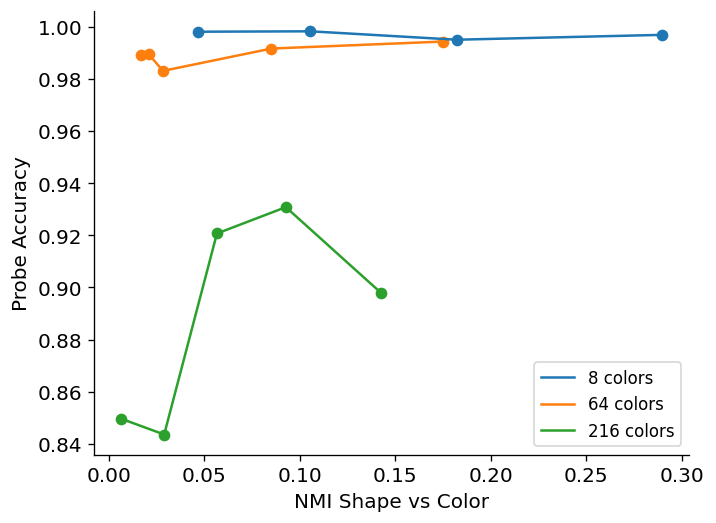

In [110]:
for exps, num_colors in zip(exp_names_by_num_colors, all_num_colors):
    if len(exps) <= 1:
        continue
    
    label = f'{num_colors} colors'
    
    probing_metrics = np.array([np.mean(all_probing_metrics[en][split][task_to_task]) for en in exps])
    probing_metrics_std = np.array([np.std(all_probing_metrics[en][split][task_to_task]) for en in exps])
    probing_metrics_err = probing_metrics_std / np.sqrt(len(exps))
    shape_color_nmis = [all_nmi_scores[en]['color:shape'] for en in exps]
    syst_accs = all_experiments.read_exp_metric(exps, acc_task_metric, 'systematic_test_acc')
    
    
    plt.scatter(shape_color_nmis, probing_metrics)
    plot = plt.plot(shape_color_nmis, probing_metrics, label=label)
    color = plot[0].get_color()
#     plt.fill_between(shape_color_nmis, probing_metrics-probing_metrics_err, probing_metrics+probing_metrics_err,
#                      alpha=1, color=color)
    plt.ylabel('Probe Accuracy')
    plt.xlabel('NMI Shape vs Color')
    
# plt.ylim(0,1)
plt.legend()
plt.savefig(
    f'exports/nmi-vs-probe-{split}-{task_to_task}.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

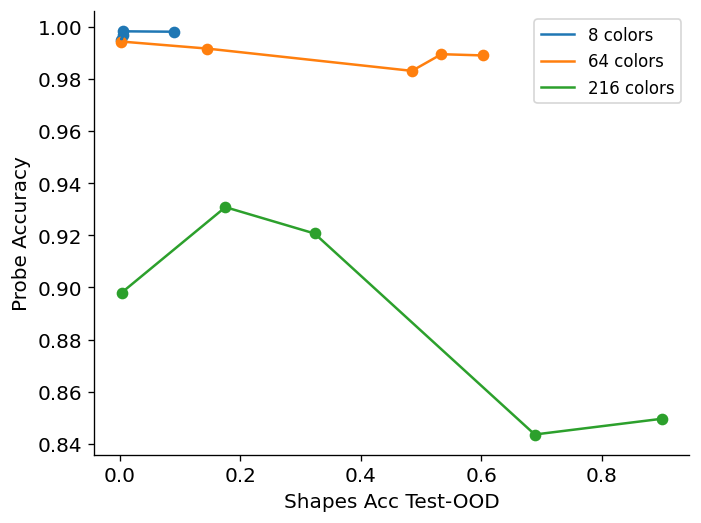

In [111]:
for exps, num_colors in zip(exp_names_by_num_colors, all_num_colors):
    if len(exps) <= 1:
        continue
        
    label = f'{num_colors} colors'
    
    probing_metrics = np.array([np.mean(all_probing_metrics[en][split][task_to_task]) for en in exps])
    probing_metrics_std = np.array([np.std(all_probing_metrics[en][split][task_to_task]) for en in exps])
    probing_metrics_err = probing_metrics_std / np.sqrt(len(exps))
    shape_color_nmis = [all_nmi_scores[en]['color:shape'] for en in exps]
    syst_accs = all_experiments.read_exp_metric(exps, acc_task_metric, 'systematic_test_acc')
    
    plt.scatter(syst_accs, probing_metrics)
    plot = plt.plot(syst_accs, probing_metrics, label=label)
    color = plot[0].get_color()
#     plt.fill_between(
#         syst_accs, probing_metrics-probing_metrics_err, probing_metrics+probing_metrics_err, color=color)
    plt.xlabel(f'{acc_task_metric.capitalize()} Acc Test-OOD')
    plt.ylabel('Probe Accuracy')
    
# plt.ylim(0,1)
plt.legend()
plt.savefig(
    f'exports/acc-vs-probe-{split}-{task_to_task}.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

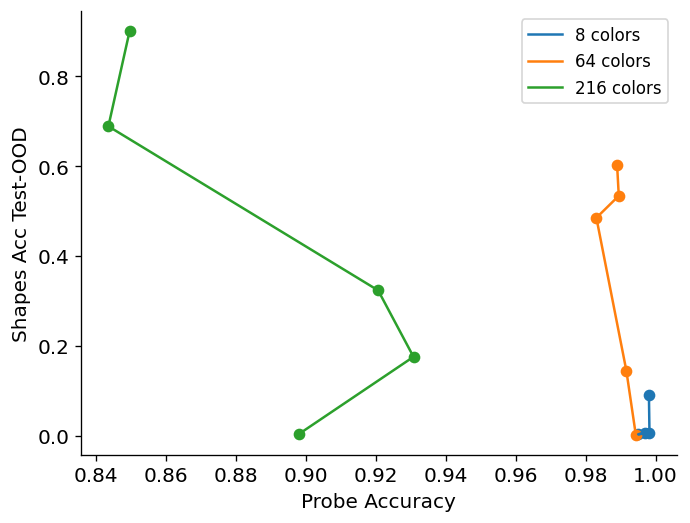

In [112]:
for exps, num_colors in zip(exp_names_by_num_colors, all_num_colors):
    if len(exps) <= 1:
        continue
        
    label = f'{num_colors} colors'
    
    probing_metrics = np.array([np.mean(all_probing_metrics[en][split][task_to_task]) for en in exps])
    probing_metrics_std = np.array([np.std(all_probing_metrics[en][split][task_to_task]) for en in exps])
    probing_metrics_err = probing_metrics_std / np.sqrt(len(exps))
    shape_color_nmis = [all_nmi_scores[en]['color:shape'] for en in exps]
    syst_accs, syst_accs_err = all_experiments.read_exp_metric(
        exps, acc_task_metric, 'systematic_test_acc', return_err=True)
    syst_accs, syst_accs_err = np.array(syst_accs), np.array(syst_accs_err)
    
    plt.scatter(probing_metrics, syst_accs)
    plot = plt.plot(probing_metrics, syst_accs, label=label)
    color = plot[0].get_color()
#     plt.fill_between(probing_metrics, syst_accs-syst_accs_err, syst_accs+syst_accs_err, color=color)
    plt.ylabel(f'{acc_task_metric.capitalize()} Acc Test-OOD')
    plt.xlabel('Probe Accuracy')
    
# plt.ylim(0,1)
plt.legend()
plt.savefig(
    f'exports/probe-vs-acc-{split}-{task_to_task}.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [113]:
split = 'complete'
task_to_task = 'colors:shapes'
# task_to_task = 'shapes:colors'
acc_task_metric = 'shapes'

valid_probing_metrics_exp = lambda n: 'overloading_to=8.json' in n or 'overloading' not in n

exp_names = sorted([exp_name for exp_name in all_probing_metrics if valid_probing_metrics_exp(exp_name)])

exp_names_by_num_colors = [sorted([en for en in all_experiments.experiment_names
                                   if is_valid(en) and filter_to_num(en, num_colors) and filter_to_base(en)],
                                   key=by_nmi) for num_colors in all_num_colors]


exp_names = [exp_name for exp_names in exp_names_by_num_colors for exp_name in exp_names]
# p_scores = [all_p_scores[exp_name][split][task] for exp_names in exp_names for exp_name in exp_names]

In [114]:
exp_names_by_num_colors

[['mmlm--n_colors=8c--mlm_probability=0.15',
  'mmlm--n_colors=8e3--mlm_probability=0.15',
  'mmlm--n_colors=8e2--mlm_probability=0.15',
  'mmlm--n_colors=8e1--mlm_probability=0.15'],
 ['mmlm--n_colors=27c--mlm_probability=0.15'],
 ['mmlm--n_colors=64e4--mlm_probability=0.15',
  'mmlm--n_colors=64e1--mlm_probability=0.15',
  'mmlm--n_colors=64c--mlm_probability=0.15',
  'mmlm--n_colors=64e2--mlm_probability=0.15',
  'mmlm--n_colors=64e3--mlm_probability=0.15'],
 ['mmlm--n_colors=125c--mlm_probability=0.15'],
 ['mmlm--n_colors=216d1--mlm_probability=0.15',
  'mmlm--n_colors=216d4--mlm_probability=0.15',
  'mmlm--n_colors=216d2--mlm_probability=0.15',
  'mmlm--n_colors=216d3--mlm_probability=0.15',
  'mmlm--n_colors=216c--mlm_probability=0.15']]

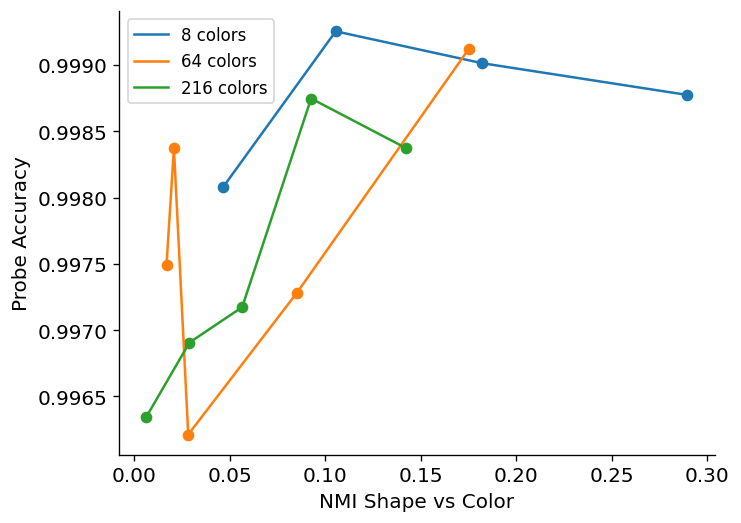

In [115]:
for exps, num_colors in zip(exp_names_by_num_colors, all_num_colors):
    if len(exps) <= 1:
        continue
    
    label = f'{num_colors} colors'
    
    probing_metrics = np.array([np.mean(all_probing_metrics[en][split][task_to_task]) for en in exps])
    probing_metrics_std = np.array([np.std(all_probing_metrics[en][split][task_to_task]) for en in exps])
    probing_metrics_err = probing_metrics_std / np.sqrt(len(exps))
    shape_color_nmis = [all_nmi_scores[en]['color:shape'] for en in exps]
    syst_accs = all_experiments.read_exp_metric(exps, acc_task_metric, 'systematic_test_acc')
    
    
    plt.scatter(shape_color_nmis, probing_metrics)
    plot = plt.plot(shape_color_nmis, probing_metrics, label=label)
    color = plot[0].get_color()
#     plt.fill_between(shape_color_nmis, probing_metrics-probing_metrics_err, probing_metrics+probing_metrics_err,
#                      alpha=1, color=color)
    plt.ylabel('Probe Accuracy')
    plt.xlabel('NMI Shape vs Color')
    
# plt.ylim(0,1)
plt.legend()
plt.savefig(
    f'exports/nmi-vs-probe-{split}-{task_to_task}.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

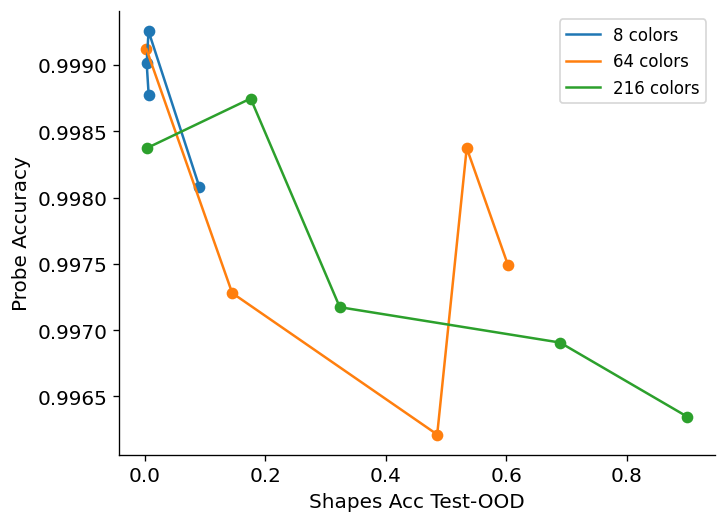

In [116]:
for exps, num_colors in zip(exp_names_by_num_colors, all_num_colors):
    if len(exps) <= 1:
        continue
        
    label = f'{num_colors} colors'
    
    probing_metrics = np.array([np.mean(all_probing_metrics[en][split][task_to_task]) for en in exps])
    probing_metrics_std = np.array([np.std(all_probing_metrics[en][split][task_to_task]) for en in exps])
    probing_metrics_err = probing_metrics_std / np.sqrt(len(exps))
    shape_color_nmis = [all_nmi_scores[en]['color:shape'] for en in exps]
    syst_accs = all_experiments.read_exp_metric(exps, acc_task_metric, 'systematic_test_acc')
    
    plt.scatter(syst_accs, probing_metrics)
    plot = plt.plot(syst_accs, probing_metrics, label=label)
    color = plot[0].get_color()
#     plt.fill_between(
#         syst_accs, probing_metrics-probing_metrics_err, probing_metrics+probing_metrics_err, color=color)
    plt.xlabel(f'{acc_task_metric.capitalize()} Acc Test-OOD')
    plt.ylabel('Probe Accuracy')
    
# plt.ylim(0,1)
plt.legend()
plt.savefig(
    f'exports/acc-vs-probe-{split}-{task_to_task}.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

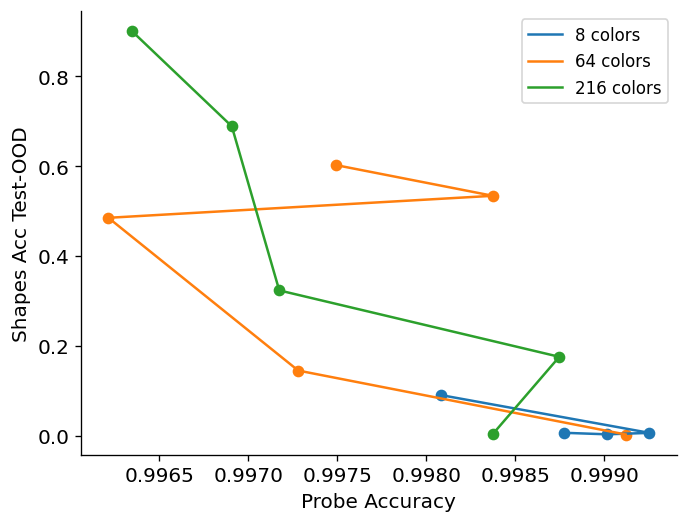

In [117]:
for exps, num_colors in zip(exp_names_by_num_colors, all_num_colors):
    if len(exps) <= 1:
        continue
        
    label = f'{num_colors} colors'
    
    probing_metrics = np.array([np.mean(all_probing_metrics[en][split][task_to_task]) for en in exps])
    probing_metrics_std = np.array([np.std(all_probing_metrics[en][split][task_to_task]) for en in exps])
    probing_metrics_err = probing_metrics_std / np.sqrt(len(exps))
    shape_color_nmis = [all_nmi_scores[en]['color:shape'] for en in exps]
    syst_accs, syst_accs_err = all_experiments.read_exp_metric(
        exps, acc_task_metric, 'systematic_test_acc', return_err=True)
    syst_accs, syst_accs_err = np.array(syst_accs), np.array(syst_accs_err)
    
    plt.scatter(probing_metrics, syst_accs)
    plot = plt.plot(probing_metrics, syst_accs, label=label)
    color = plot[0].get_color()
#     plt.fill_between(probing_metrics, syst_accs-syst_accs_err, syst_accs+syst_accs_err, color=color)
    plt.ylabel(f'{acc_task_metric.capitalize()} Acc Test-OOD')
    plt.xlabel('Probe Accuracy')
    
# plt.ylim(0,1)
plt.legend()
plt.savefig(
    f'exports/probe-vs-acc-{split}-{task_to_task}.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

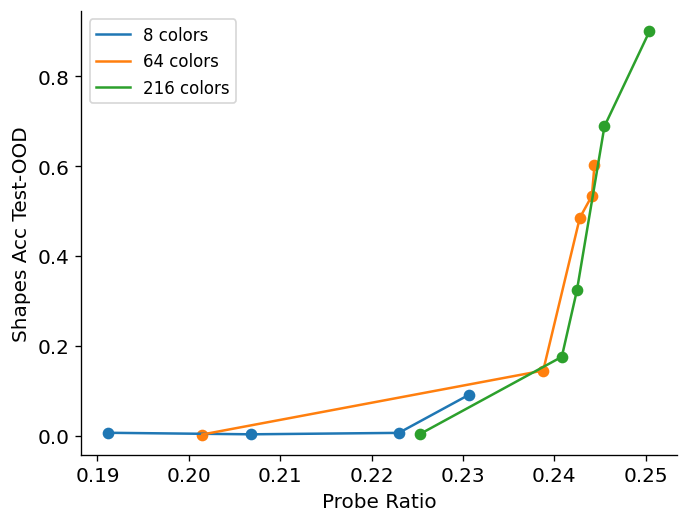

In [118]:
for exps, num_colors in zip(exp_names_by_num_colors, all_num_colors):
    if len(exps) <= 1:
        continue
        
    label = f'{num_colors} colors'


    probing_metrics = np.array([np.mean(all_probing_metrics[en][split][task_to_task]) for en in exps])
    probing_metrics_std = np.array([np.std(all_probing_metrics[en][split][task_to_task]) for en in exps])
    probing_metrics_err = probing_metrics_std / np.sqrt(len(exps))
    
    probing_ratio = (np.array([np.mean(all_probing_metrics[en][split]['shapes:shapes']) for en in exps]) /
                     (np.array([np.mean(all_probing_metrics[en][split]['shapes:colors']) for en in exps]) + 
                      np.array([np.mean(all_probing_metrics[en][split]['shapes:materials']) for en in exps]) + 
                      np.array([np.mean(all_probing_metrics[en][split]['shapes:sizes']) for en in exps]) + 
                      np.array([np.mean(all_probing_metrics[en][split]['shapes:shapes']) for en in exps])))
    shape_color_nmis = [all_nmi_scores[en]['color:shape'] for en in exps]
    syst_accs = all_experiments.read_exp_metric(exps, acc_task_metric, 'systematic_test_acc')
    

    plt.scatter(probing_ratio, syst_accs)
    plot = plt.plot(probing_ratio, syst_accs, label=label)
    color = plot[0].get_color()
    plt.ylabel(f'{acc_task_metric.capitalize()} Acc Test-OOD')
    plt.xlabel('Probe Ratio')
    
# plt.xlim(0.5,1.05)
plt.legend()
plt.savefig(
    f'exports/acc-vs-probe-ratio-{split}.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

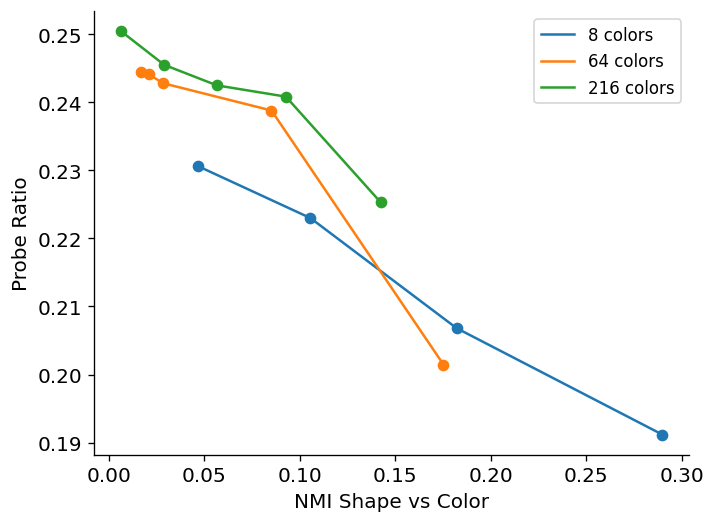

In [119]:
for exps, num_colors in zip(exp_names_by_num_colors, all_num_colors):
    if len(exps) <= 1:
        continue
        
    label = f'{num_colors} colors'
    
    probing_ratio = (np.array([np.mean(all_probing_metrics[en][split]['shapes:shapes']) for en in exps]) /
                     (np.array([np.mean(all_probing_metrics[en][split]['shapes:colors']) for en in exps]) + 
                      np.array([np.mean(all_probing_metrics[en][split]['shapes:materials']) for en in exps]) + 
                      np.array([np.mean(all_probing_metrics[en][split]['shapes:sizes']) for en in exps]) + 
                      np.array([np.mean(all_probing_metrics[en][split]['shapes:shapes']) for en in exps])))

    shape_color_nmis = [all_nmi_scores[en]['color:shape'] for en in exps]
    syst_accs = all_experiments.read_exp_metric(exps, acc_task_metric, 'systematic_test_acc')
    

    plt.scatter(shape_color_nmis, probing_ratio)
    plot = plt.plot(shape_color_nmis, probing_ratio, label=label)
    color = plot[0].get_color()
    plt.xlabel('NMI Shape vs Color')
    plt.ylabel('Probe Ratio')
    
# plt.ylim(0,1)
plt.legend()
plt.savefig(
    f'exports/probe-ratio-vs-nmi-{split}.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [120]:
for exps, num_colors in zip(exp_names_by_num_colors, all_num_colors):
    if len(exps) <= 1:
        continue
        
    label = f'{num_colors} colors'
    
    
    probing_metrics = np.array([np.mean(all_probing_metrics[en][split][task_to_task]) for en in exps])
    probing_metrics_std = np.array([np.std(all_probing_metrics[en][split][task_to_task]) for en in exps])
    probing_metrics_err = probing_metrics_std / np.sqrt(len(exps))
    
 

    for t in ['shapes', 'colors', 'materials', 'sizes']:
        probing_ratio = (np.array([np.mean(all_probing_metrics[en][split][f'{t}:{t}']) for en in exps]) /
                         sum(np.array([np.mean(all_probing_metrics[en][split][f'{t}:{base_t}']) for en in exps]) 
                             for base_t in ['shapes', 'colors', 'materials', 'sizes']))
        print(num_colors, t)
        print(probing_ratio)

8 shapes
[0.19119237 0.20681756 0.22298531 0.23061272]
8 colors
[0.19040961 0.19800164 0.20853551 0.21986471]
8 materials
[0.23329243 0.23412203 0.23133444 0.22884957]
8 sizes
[0.23716179 0.23739587 0.23428115 0.23202849]
64 shapes
[0.20146082 0.23878864 0.24279763 0.24411786 0.24440188]
64 colors
[0.17705473 0.19226147 0.20085686 0.20506103 0.21347417]
64 materials
[0.24246813 0.24715312 0.24507795 0.24181261 0.23797356]
64 sizes
[0.24595502 0.24831948 0.24634252 0.24281226 0.23935909]
216 shapes
[0.22530708 0.240826   0.24247961 0.24549452 0.25042293]
216 colors
[0.16311993 0.16897324 0.16645562 0.17431754 0.18317027]
216 materials
[0.25650707 0.25355647 0.25398409 0.25806993 0.25408435]
216 sizes
[0.26259483 0.25643608 0.2584222  0.26286752 0.25747492]


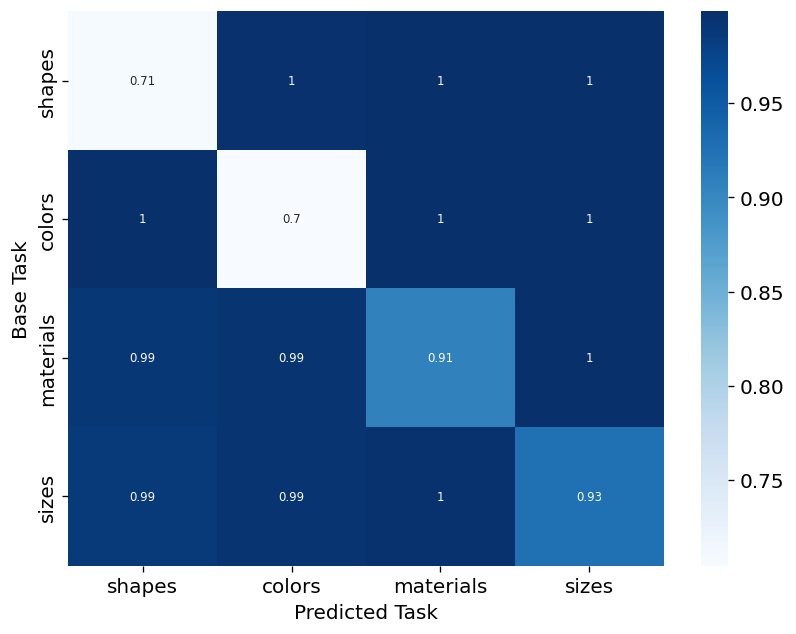

In [121]:
import seaborn as sns

n_colors = 8

set_ = 'complete'
mtasks = ['shapes', 'colors', 'materials', 'sizes']

matrix = np.empty((len(mtasks),len(mtasks)))
for t_from, t_to in product(mtasks, repeat=2):
    matrix[mtasks.index(t_from)][mtasks.index(t_to)] = np.mean(
        all_probing_metrics[f'mmlm--n_colors={n_colors}c--mlm_probability=0.15'][set_][f'{t_from}:{t_to}'])

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, cmap="Blues", xticklabels=mtasks, yticklabels=mtasks)
plt.ylabel('Base Task')
plt.xlabel('Predicted Task')
# plt.title('Confusion Matrix')
plt.show()

# O-Score

In [122]:
# o_score_metric = 'o_scores'
# o_score_metric = 'o_scores_within_task'
o_score_metric = 'o_scores_within_color_shape'

In [123]:
# all_experiments.get_exp(all_experiments.experiment_names[0]).runs[0].results[p_score_metric]

In [124]:
from collections import defaultdict

def merge_o_scores(all_o_scores):
    merged_o_scores = {}
    for k0 in all_o_scores[0]:
        merged_o_scores[k0] = defaultdict(list)
        for k1 in all_o_scores[0][k0]:
            for o_scores in all_o_scores:
                merged_o_scores[k0][k1].extend(o_scores[k0][k1])
        merged_o_scores[k0] = dict(merged_o_scores[k0])
    return merged_o_scores
            

all_o_scores = {
    en: merge_o_scores(
        [run.results[o_score_metric] for run in all_experiments.get_exp(en).runs if o_score_metric in run.results])
    for en in all_experiments.experiment_names
    if any(o_score_metric in r.results for r in all_experiments.get_exp(en).runs)
}

In [125]:
list(all_o_scores.keys())

['mmlm--n_colors=125c--mlm_probability=0.15',
 'mmlm--n_colors=216c--mlm_probability=0.15',
 'mmlm--n_colors=64c--mlm_probability=0.15',
 'mmlm--n_colors=8c--d_hidden=128',
 'mmlm--n_colors=8c--mlm_probability=0.15',
 'mmlm--n_colors=27c--mlm_probability=0.15',
 'mmlm--n_colors=216d1--mlm_probability=0.15',
 'mmlm--n_colors=216d2--mlm_probability=0.15',
 'mmlm--n_colors=216d3--mlm_probability=0.15',
 'mmlm--n_colors=216d4--mlm_probability=0.15',
 'mmlm--n_colors=8e2--mlm_probability=0.15',
 'mmlm--n_colors=216d2--mlm_probability=0.15--sim-cvlearning',
 'mmlm--n_colors=8c--d_hidden=32',
 'mmlm--n_colors=8c--d_hidden=64',
 'mmlm--n_colors=8e3--mlm_probability=0.15',
 'mmlm--n_colors=64e1--mlm_probability=0.15',
 'mmlm--n_colors=64e2--mlm_probability=0.15',
 'mmlm--n_colors=8e1--mlm_probability=0.15',
 'mmlm--n_colors=64e3--mlm_probability=0.15',
 'mmlm--n_colors=64e4--mlm_probability=0.15']

In [126]:
filter_to_overloading = lambda en: '--overloading' in en and not 'indep' in en
filter_to_underloading = lambda en: '--overloading' in en and 'indep' in en
filter_to_underloading_indep = lambda en: '--overloading' in en and 'indep' in en and 'no-indep' not in en
filter_to_underloading_no_indep = lambda en: '--overloading' in en and 'indep' in en and 'no-indep' in en
filter_to_capacity = lambda en: '--d_hidden' in en
filter_to_base = lambda en: '--overloading' not in en and '--d_hidden' not in en and 'sim-cvlearning' not in en
filter_to_num = lambda en, num: f'n_colors={num}' in en if num else True

overloading_exps = [en for en in all_experiments.experiment_names if '--overloading' in en]
capacity_exps = [en for en in all_experiments.experiment_names if '--d_hidden' in en]
base_exps = list(set(all_experiments.experiment_names) - set(overloading_exps) - set(capacity_exps))

by_ncolors_exps = {num: 
    [en for en in all_experiments.experiment_names if f'n_colors={num}' in en] for num in [8, 27, 64, 125, 216]}

is_valid = lambda en: en in all_o_scores# and 'color:shape' in all_nmi_scores[en]

In [127]:
# def get_scatter_info_from(exps):
#     test_accs = all_experiments.read_exp_metric(exps, 'shapes', 'test_acc')
#     syst_accs = all_experiments.read_exp_metric(exps, 'shapes', 'systematic_test_acc')
#     p_scores = [all_p_scores[en]['p_scores'] for en in exps]
#     return p_scores, test_accs, syst_accs

In [128]:
split = 'complete'
task = 'colors'
acc_task_metric = 'color'

valid_o_score_exp = lambda n: 'overloading_to=8.json' in n or 'overloading' not in n

exp_names = sorted([exp_name for exp_name in all_o_scores if valid_o_score_exp(exp_name)])

exp_names_by_num_colors = [sorted([en for en in all_experiments.experiment_names
                                   if is_valid(en) and filter_to_num(en, num_colors) and filter_to_base(en)],
                                   key=by_nmi) for num_colors in all_num_colors]


exp_names = [exp_name for exp_names in exp_names_by_num_colors for exp_name in exp_names]
# p_scores = [all_p_scores[exp_name][split][task] for exp_names in exp_names for exp_name in exp_names]

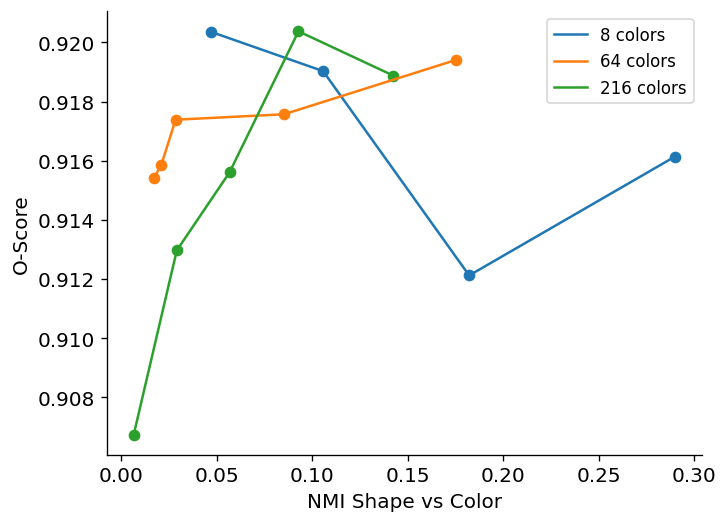

In [129]:
for exps, num_colors in zip(exp_names_by_num_colors, all_num_colors):
    label = f'{num_colors} colors'
    if len(exps) <= 1:
        continue

    o_scores = np.array([np.mean(all_o_scores[en][split][task]) for en in exps])
    o_scores_err = np.array([np.std(all_o_scores[en][split][task]) for en in exps]) / np.sqrt(len(exps))
    shape_color_nmis = [all_nmi_scores[en]['color:shape'] for en in exps]
    syst_accs = all_experiments.read_exp_metric(exps, acc_task_metric, 'systematic_test_acc')
    
    
    plt.scatter(shape_color_nmis, o_scores)
    plot = plt.plot(shape_color_nmis, o_scores, label=label)
#     plt.fill_between(shape_color_nmis, p_scores-p_scores_err, p_scores+p_scores_err, color=plot[0].get_color())
    plt.ylabel('O-Score')
    plt.xlabel('NMI Shape vs Color')
    
# plt.ylim(0,1)
plt.legend()
plt.savefig(
    f'exports/nmi-vs-o-score-{split}-{task}.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

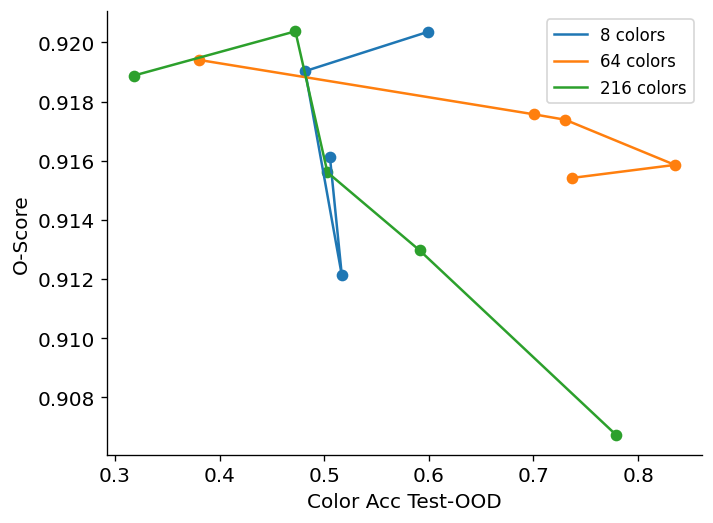

In [130]:
for exps, num_colors in zip(exp_names_by_num_colors, all_num_colors):
    if len(exps) <= 1:
        continue
        
    label = f'{num_colors} colors'
    
    o_scores = np.array([np.mean(all_o_scores[en][split][task]) for en in exps])
    o_scores_err = np.array([np.std(all_o_scores[en][split][task]) for en in exps]) / np.sqrt(len(exps))
    shape_color_nmis = [all_nmi_scores[en]['color:shape'] for en in exps]
    syst_accs = all_experiments.read_exp_metric(exps, acc_task_metric, 'systematic_test_acc')
    
    plt.scatter(syst_accs, o_scores)
    plot = plt.plot(syst_accs, o_scores, label=label)
#     plt.fill_between(syst_accs, p_scores-p_scores_err, p_scores+p_scores_err, color=plot[0].get_color())
    plt.xlabel(f'{acc_task_metric.capitalize()} Acc Test-OOD')
    plt.ylabel('O-Score')
    
# plt.ylim(0,1)
plt.legend()
plt.savefig(
    f'exports/acc-{acc_task_metric}-vs-o-score-in-{split}-for-{task}.pdf',
    format='pdf', dpi=300, bbox_inches='tight')
plt.show()

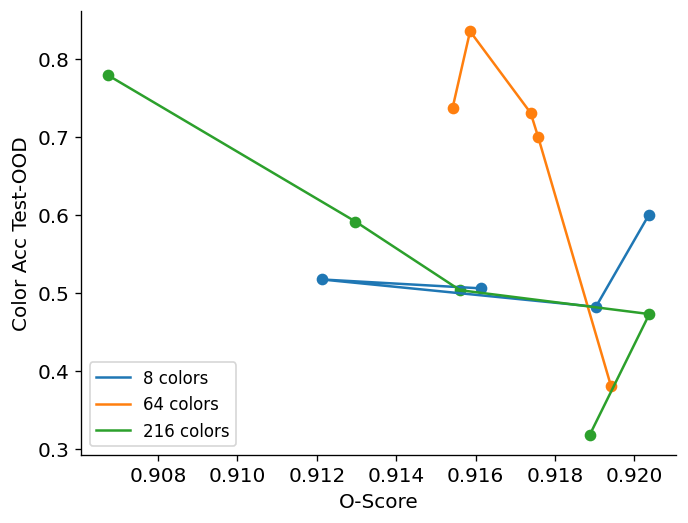

In [131]:
for exps, num_colors in zip(exp_names_by_num_colors, all_num_colors):
    if len(exps) <= 1:
        continue
        
    label = f'{num_colors} colors'
    
    o_scores = np.array([np.mean(all_o_scores[en][split][task]) for en in exps])
    o_scores_err = np.array([np.std(all_o_scores[en][split][task]) for en in exps]) / np.sqrt(len(exps))
    shape_color_nmis = [all_nmi_scores[en]['color:shape'] for en in exps]
    syst_accs, syst_accs_err = all_experiments.read_exp_metric(
        exps, acc_task_metric, 'systematic_test_acc', return_err=True)
    syst_accs, syst_accs_err = np.array(syst_accs), np.array(syst_accs_err)
    
    plt.scatter(o_scores, syst_accs)
    plot = plt.plot(o_scores, syst_accs, label=label)
#     plt.fill_between(p_scores, syst_accs-syst_accs_err, syst_accs+syst_accs_err, color=plot[0].get_color())
    plt.ylabel(f'{acc_task_metric.capitalize()} Acc Test-OOD')
    plt.xlabel('O-Score')
    
# plt.ylim(0,1)
plt.legend()
plt.savefig(
    f'exports/o-score-vs-acc-{acc_task_metric}-in-{split}-for-{task}.pdf',
    format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [132]:
split = 'complete'
task = 'shapes'
acc_task_metric = 'shapes'

valid_p_score_exp = lambda n: 'overloading_to=8.json' in n or 'overloading' not in n

exp_names = sorted([exp_name for exp_name in all_o_scores if valid_o_score_exp(exp_name)])

exp_names_by_num_colors = [sorted([en for en in all_experiments.experiment_names
                                   if is_valid(en) and filter_to_num(en, num_colors) and filter_to_base(en)],
                                   key=by_nmi) for num_colors in all_num_colors]


exp_names = [exp_name for exp_names in exp_names_by_num_colors for exp_name in exp_names]
# p_scores = [all_p_scores[exp_name][split][task] for exp_names in exp_names for exp_name in exp_names]

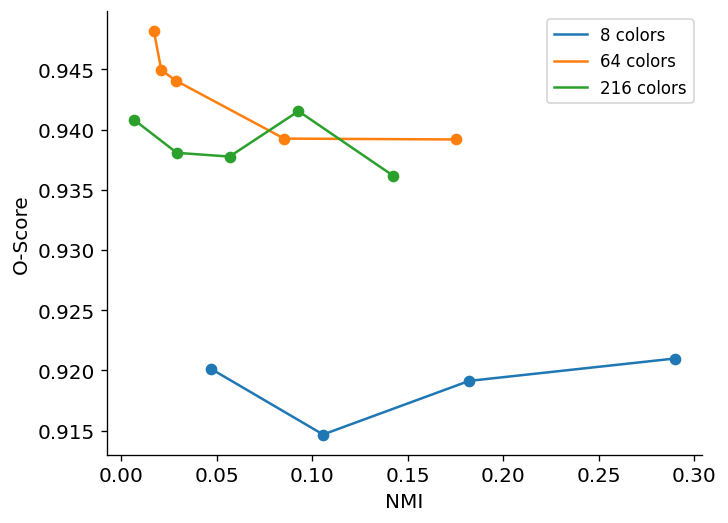

In [133]:
for exps, num_colors in zip(exp_names_by_num_colors, all_num_colors):
    label = f'{num_colors} colors'
    if len(exps) <= 1:
        continue

    o_scores = np.array([np.mean(all_o_scores[en][split][task]) for en in exps])
    o_scores_err = np.array([np.std(all_o_scores[en][split][task]) for en in exps]) / np.sqrt(len(exps))
    shape_color_nmis = [all_nmi_scores[en]['color:shape'] for en in exps]
    syst_accs = all_experiments.read_exp_metric(exps, acc_task_metric, 'systematic_test_acc')
    
    plt.scatter(shape_color_nmis, o_scores)
    plot = plt.plot(shape_color_nmis, o_scores, label=label)
#     plt.fill_between(shape_color_nmis, p_scores-p_scores_err, p_scores+p_scores_err, color=plot[0].get_color())
    plt.ylabel('O-Score')
    plt.xlabel('NMI')
    
# plt.ylim(0,1)
plt.legend()
plt.savefig(
    f'exports/nmi-vs-o-score-{split}-{task}.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

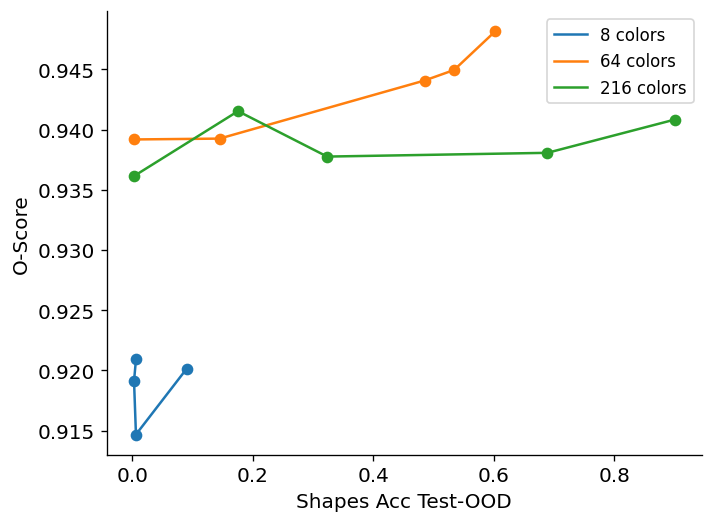

In [134]:
for exps, num_colors in zip(exp_names_by_num_colors, all_num_colors):
    if len(exps) <= 1:
        continue
        
    label = f'{num_colors} colors'
    
    o_scores = np.array([np.mean(all_o_scores[en][split][task]) for en in exps])
    o_scores_err = np.array([np.std(all_o_scores[en][split][task]) for en in exps]) / np.sqrt(len(exps))
    shape_color_nmis = [all_nmi_scores[en]['color:shape'] for en in exps]
    syst_accs = all_experiments.read_exp_metric(exps, acc_task_metric, 'systematic_test_acc')

    plt.scatter(syst_accs, o_scores)
    plot = plt.plot(syst_accs, o_scores, label=label)
#     plt.fill_between(syst_accs, p_scores-p_scores_err, p_scores+p_scores_err, color=plot[0].get_color())
    plt.xlabel(f'{acc_task_metric.capitalize()} Acc Test-OOD')
    plt.ylabel('O-Score')
    
# plt.ylim(0,1)
plt.legend()
plt.savefig(
    f'exports/acc-{acc_task_metric}-vs-o-score-in-{split}-for-{task}.pdf',
    format='pdf', dpi=300, bbox_inches='tight')
plt.show()

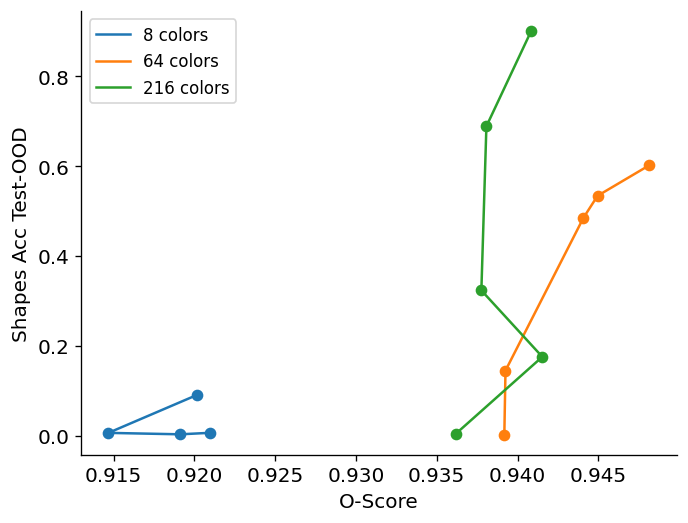

In [135]:
for exps, num_colors in zip(exp_names_by_num_colors, all_num_colors):
    if len(exps) <= 1:
        continue
        
    label = f'{num_colors} colors'
    
    o_scores = np.array([np.mean(all_o_scores[en][split][task]) for en in exps])
    o_scores_err = np.array([np.std(all_o_scores[en][split][task]) for en in exps]) / np.sqrt(len(exps))
    shape_color_nmis = [all_nmi_scores[en]['color:shape'] for en in exps]
    syst_accs, syst_accs_err = all_experiments.read_exp_metric(
        exps, acc_task_metric, 'systematic_test_acc', return_err=True)
    syst_accs, syst_accs_err = np.array(syst_accs), np.array(syst_accs_err)
    
    plt.scatter(o_scores, syst_accs)
    plot = plt.plot(o_scores, syst_accs, label=label)
#     plt.fill_between(o_scores, syst_accs-syst_accs_err, syst_accs+syst_accs_err, color=plot[0].get_color())
    plt.ylabel(f'{acc_task_metric.capitalize()} Acc Test-OOD')
    plt.xlabel('O-Score')
    
# plt.ylim(0,1)
plt.legend()
plt.savefig(
    f'exports/o-score-vs-acc-{acc_task_metric}-in-{split}-for-{task}.pdf',
    format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Missing metrics in Experiments

In [136]:
n_runs_by_name = [(len(exp.runs), exp_name.replace('mmlm--',''))
                  for exp_name, exp in all_experiments.indexed_experiments.items()]
n_runs_by_name = sorted(n_runs_by_name)

print('Seeds ran per Experiments\n')
for n_runs, exp_name in n_runs_by_name:
    if 'overloading' in exp_name and not exp_name.endswith('overloading_to=8'):
        continue
    if 'sim-cvlearning' in exp_name:
        continue

    print(f'{exp_name:55.55s}: {n_runs}')

Seeds ran per Experiments

n_colors=64e4--mlm_probability=0.15                    : 1
n_colors=125c--mlm_probability=0.15                    : 3
n_colors=216c--mlm_probability=0.15                    : 3
n_colors=216c--mlm_probability=0.15--overloading_to=8  : 3
n_colors=216d1--mlm_probability=0.15                   : 3
n_colors=216d2--mlm_probability=0.15                   : 3
n_colors=216d3--mlm_probability=0.15                   : 3
n_colors=216d4--mlm_probability=0.15                   : 3
n_colors=27c--mlm_probability=0.15                     : 3
n_colors=64c--mlm_probability=0.15                     : 3
n_colors=64c--mlm_probability=0.15--overloading_to=8   : 3
n_colors=64e1--mlm_probability=0.15                    : 3
n_colors=64e2--mlm_probability=0.15                    : 3
n_colors=64e3--mlm_probability=0.15                    : 3
n_colors=8c--d_hidden=128                              : 3
n_colors=8c--d_hidden=32                               : 3
n_colors=8c--d_hidden=64     

In [137]:
optional_metrics = ['p_scores', 'p_scores_within_task', 'probing_metrics',
                    'o_scores_within_task', 'o_scores_within_task', 'o_scores']
missing = {m: [] for m in optional_metrics}
all_ = 0
for exp in all_experiments.experiments:
    if 'overloading' in exp.exp_name and not exp.exp_name.endswith('overloading_to=8'):
        continue
    for run in exp.runs:
        for m in optional_metrics:
            if m not in run.results:
                missing[m].append({'exp_name': exp.exp_name, 'seed': run.seed})
                
        all_ += 1 

In [138]:
for k in missing:
    print(k, f'({len(missing[k])}/{all_})')
    for e in missing[k]:
        print(e)
    print()

p_scores (0/59)

p_scores_within_task (3/59)
{'exp_name': 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=8', 'seed': 42}
{'exp_name': 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=8', 'seed': 16814}
{'exp_name': 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=8', 'seed': 3462}

probing_metrics (3/59)
{'exp_name': 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=8', 'seed': 42}
{'exp_name': 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=8', 'seed': 16814}
{'exp_name': 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=8', 'seed': 3462}

o_scores_within_task (6/59)
{'exp_name': 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=8', 'seed': 42}
{'exp_name': 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=8', 'seed': 42}
{'exp_name': 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=8', 'seed': 16814}
{'exp_name': 'mmlm--n_colors=64c--mlm_probability=0.15--overloading_to=8', 'seed': 16814}
{'exp_name': 'mm

In [139]:
[p for p in Path('outputs/').iterdir()][0].name

'mmlm--n_colors=216c--mlm_probability=0.15--overloading_to=8'

In [140]:
all_ran_exps = set(
    [p.name for p in Path('outputs/').glob('mmlm--*')
     if p.is_dir() and
     (p.name.endswith('overloading_to=8') or
     'overloading' not in p.name) and
     'sim-cvlearning' not in p.name and
     'lr=' not in p.name and
     'n_layers' not in p.name
])

In [141]:
all_exps_with_results = set(
    [p.stem for p in Path('outputs/results/').glob('mmlm--*.json')
     if (p.name.endswith('overloading_to=8.json') or
     'overloading' not in p.name) and
     'sim-cvlearning' not in p.name and
     'lr=' not in p.name and
     'n_layers' not in p.name
])

In [142]:
len(all_exps_with_results), len(all_ran_exps)

(57, 61)

In [143]:
all_ran_exps - all_exps_with_results

{'mmlm--n_colors=64e4--mlm_probability=0.15',
 'mmlm--n_colors=64e4--mlm_probability=0.15--seed=2119',
 'mmlm--n_colors=64e4--mlm_probability=0.15--seed=32748',
 'mmlm--n_colors=8c--mlm_probability=0.15--seed=24013'}

In [144]:
# metric_key = 'o_scores_within_task'

# path_obj = Path('outputs/results')
# exp_files = list(path_obj.glob('*.json'))
# random.shuffle(exp_files)
# count = 0
# for exp_file in exp_files:
#     exp_name = exp_file.stem
#     if 'multimodal-pretraining' in exp_name:
#         continue
#     if 'overloading' in exp_name and 'overloading_to=8.json' not in exp_name:
#         continue
        
#     with open(f'outputs/results/{exp_name}.json') as fp:
#         all_results = json.load(fp)

#     if metric_key in all_results:
#         count += 1
#         del all_results[metric_key]
        
#     with open(f'outputs/results/{exp_name}.json.tmp', 'w') as fp:
#         json.dump(all_results, fp)

#     os.rename(f'outputs/results/{exp_name}.json.tmp', f'outputs/results/{exp_name}.json')
    
# print(count, 'deleted')